<div style='background-color: dark; padding: 20px'>
<h1 style='color: orange; fontweight: bold'>Détectez des faux billets avec Python</h1>
</div>

<div style='background-color: white; padding: 20px'>
<h3 style='color: black; fontweight: bold'><b>Objectifs de la mission</b>:</h3>
<p style='color: black; fontweight: bold'>L’Organisation nationale de lutte contre le faux-monnayage (ONCFM) veut mettre en place des méthodes d’identification des contrefaçons de billets en euros. Il s'agira de réaliser une modélisation qui serait capable d’identifier automatiquement les vrais des faux billets, et ce simplement à partir de certaines dimensions du billet et des éléments qui le composent. On mettra en concurrence deux méthodes de prédiction :<br><br>
● une régression logistique classique<br>
● un k-means, duquel seront utilisés les centroïdes pour réaliser la prédiction.</p>
</div>

<div style='background-color: steelblue; padding: 20px'>
<h2 style='color: white; fontweight: bold'>Étape 1 - Chargement, exploration et prétraitement des données</h2>
</div>

<div style='background-color: white; padding: 20px'>
<h3 style='color: blue; fontweight: bold'>Étape 1.1 - Import des bibliothèques Python nécessaires</h3>
</div>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines

import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats

import statistics

from adjustText import adjust_text

import pickle
import warnings

<div style='background-color: white; padding: 20px'>
<h3 style='color: blue; fontweight: bold'>Étape 1.2 - Chargement et exploration des données</h3>
</div>

In [2]:
# Charger les données et visualiser les premières lignes du dataframe
df = pd.read_csv('billets.csv', sep=';')
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [3]:
# Afficher les dimensions du dataframe
# Celui-ci contient 1500 lignes (billets) et 7 variables 
df.shape

(1500, 7)

In [4]:
# Afficher un échantillon de billets sélectionnés de façon aléatoire
df.sample(10, random_state=42)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1116,False,172.26,103.90,104.12,4.99,3.42,111.27
1368,False,171.65,104.32,104.38,5.65,3.24,112.30
422,True,171.53,103.53,103.63,4.04,2.96,112.76
413,True,172.30,103.66,103.50,NaN,3.16,112.95
451,True,172.17,103.79,103.54,4.07,2.78,113.03
861,True,171.86,104.21,103.74,4.43,2.90,113.65
1063,False,171.44,103.99,104.04,4.81,3.49,111.74
741,True,172.17,103.75,103.29,4.43,2.88,113.38
1272,False,171.73,103.74,104.38,5.14,3.16,111.73
259,True,172.35,103.62,103.78,4.38,2.86,113.28


In [5]:
# Afficher le nombre de valeurs non nulles et le type de données dans chaque colonne
# Nous avons des valeurs manquantes dans la colonne "margin_low"
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [6]:
# Afficher le nombre de valeurs manquantes dans les différentes colonnes
df.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [7]:
# Afficher le nombre de doublons
df.duplicated().sum()

0

In [8]:
df.is_genuine.value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

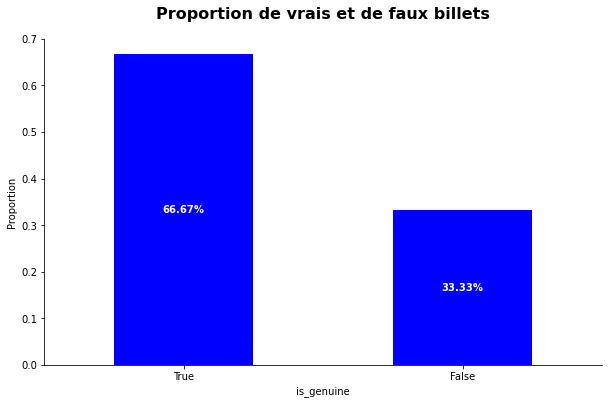

In [9]:
# Afficher la proportion de chaque classe (vrais billets et faux billets) dans le nombre total de billets
plt.figure(figsize=(10, 6))
ax = df['is_genuine'].value_counts(normalize=True).plot(kind='bar', color='blue')

plt.title('Proportion de vrais et de faux billets', fontweight='bold', fontsize=16, pad=20)
plt.xlabel('is_genuine')
plt.ylabel('Proportion')

for p in ax.patches:
    ax.annotate("{:.2%}".format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height() * 0.50), ha='center', va='center', color='white', fontweight='bold')
    
ax.spines[['top', 'right']].set_visible(False)
plt.xticks(rotation=0)
ax.set_axisbelow(True)
plt.show()


<div style='background-color: white; padding: 20px'>
<p style='color: black'>On avons un déséquilibre de classe, les vrais billets étant deux fois plus nombreux que les faux.<br><br><b>A présent, nous allons créer un dataset sans les valeurs manquantes</b>.</p></div>

In [10]:
# Créer une dataframe sans les valeurs manquantes
df_without_nan = df.dropna()

In [11]:
# Vérifier si les valeurs manquantes ont été supprimées
df_without_nan.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [12]:
# Afficher les statistiques pour les vrais billets 
df_true = df_without_nan.loc[df_without_nan['is_genuine'] == True]
df_true.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000
mean,171.988476,103.951679,103.809094,4.116097,3.052544,113.203059
std,0.301402,0.301518,0.288862,0.319124,0.185425,0.356123
min,171.040000,103.140000,102.910000,2.980000,2.270000,111.760000
25%,171.790000,103.745000,103.610000,3.905000,2.925000,112.960000
50%,171.990000,103.950000,103.810000,4.110000,3.050000,113.200000
75%,172.200000,104.140000,104.000000,4.340000,3.180000,113.460000
max,172.920000,104.860000,104.950000,5.040000,3.740000,114.320000


In [13]:
# Afficher les statistiques pour les faux billets 
df_false = df_without_nan.loc[df_without_nan['is_genuine'] == False]
df_false.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000
mean,171.901402,104.188537,104.143272,5.215935,3.351504,111.632114
std,0.305473,0.224418,0.271683,0.553531,0.179343,0.615343
min,171.040000,103.510000,103.430000,3.820000,2.920000,109.490000
25%,171.697500,104.040000,103.950000,4.840000,3.227500,111.200000
50%,171.910000,104.180000,104.160000,5.190000,3.350000,111.630000
75%,172.092500,104.330000,104.320000,5.592500,3.472500,112.030000
max,173.010000,104.880000,104.950000,6.900000,3.910000,113.850000


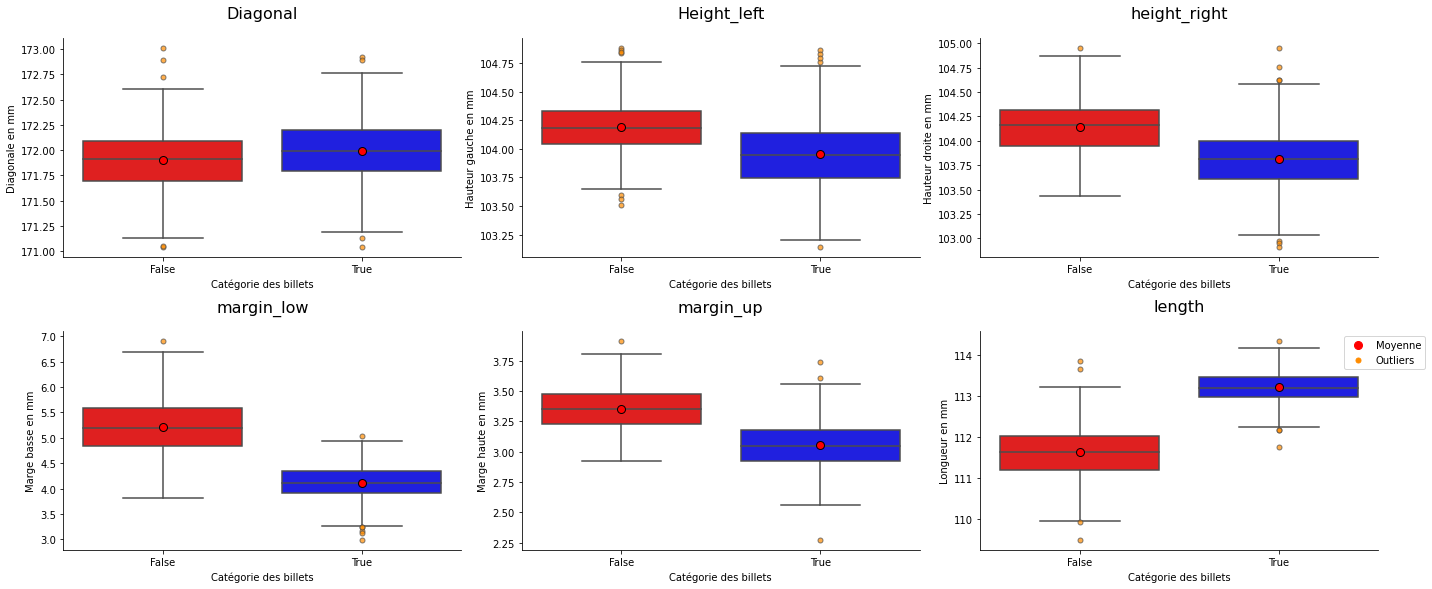

In [14]:
# Comparer les faux et les vrais billets à l'aide d'un boxplot
plt.figure(figsize=(20, 16))

palette = ['red', 'blue']

plt.subplot(4,3,1)
meanprops = dict(marker='o', markersize=8, markeredgecolor='black', markerfacecolor='red')
mean_marker = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=8, label='Moyenne')
flierprops = dict(marker='o', markersize=5, markerfacecolor='darkorange', linestyle='none', alpha=0.7)
outliers_marker = mlines.Line2D([], [], color='darkorange', marker='o', linestyle='None', markersize=5, label='Outliers')
sns.boxplot(x='is_genuine', y='diagonal', data=df_without_nan, palette=palette, meanprops=meanprops, showmeans=True, flierprops=flierprops)
plt.title('Diagonal', fontsize=16, pad=20)
plt.xlabel('Catégorie des billets')
plt.ylabel('Diagonale en mm')

plt.subplot(4,3,2)
meanprops = dict(marker='o', markersize=8, markeredgecolor='black', markerfacecolor='red')
mean_marker = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=8, label='Moyenne')
flierprops = dict(marker='o', markersize=5, markerfacecolor='darkorange', linestyle='none', alpha=0.7)
outliers_marker = mlines.Line2D([], [], color='darkorange', marker='o', linestyle='None', markersize=5, label='Outliers')
sns.boxplot(x='is_genuine', y='height_left', data=df_without_nan, palette=palette, meanprops=meanprops, showmeans=True, flierprops=flierprops)
plt.title('Height_left', fontsize=16, pad=20)
plt.xlabel('Catégorie des billets')
plt.ylabel('Hauteur gauche en mm')

plt.subplot(4,3,3)
meanprops = dict(marker='o', markersize=8, markeredgecolor='black', markerfacecolor='red')
mean_marker = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=8, label='Moyenne')
flierprops = dict(marker='o', markersize=5, markerfacecolor='darkorange', linestyle='none', alpha=0.7)
outliers_marker = mlines.Line2D([], [], color='darkorange', marker='o', linestyle='None', markersize=5, label='Outliers')
sns.boxplot(x='is_genuine', y='height_right', data=df_without_nan, palette=palette, meanprops=meanprops, showmeans=True, flierprops=flierprops)
plt.title('height_right', fontsize=16, pad=20)
plt.xlabel('Catégorie des billets')
plt.ylabel('Hauteur droite en mm')

plt.subplot(4,3,4)
meanprops = dict(marker='o', markersize=8, markeredgecolor='black', markerfacecolor='red')
mean_marker = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=8, label='Moyenne')
flierprops = dict(marker='o', markersize=5, markerfacecolor='darkorange', linestyle='none', alpha=0.7)
outliers_marker = mlines.Line2D([], [], color='darkorange', marker='o', linestyle='None', markersize=5, label='Outliers')
sns.boxplot(x='is_genuine', y='margin_low', data=df_without_nan, palette=palette, meanprops=meanprops, showmeans=True, flierprops=flierprops)
plt.title('margin_low', fontsize=16, pad=20)
plt.xlabel('Catégorie des billets')
plt.ylabel('Marge basse en mm')

plt.subplot(4,3,5)
meanprops = dict(marker='o', markersize=8, markeredgecolor='black', markerfacecolor='red')
mean_marker = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=8, label='Moyenne')
flierprops = dict(marker='o', markersize=5, markerfacecolor='darkorange', linestyle='none', alpha=0.7)
outliers_marker = mlines.Line2D([], [], color='darkorange', marker='o', linestyle='None', markersize=5, label='Outliers')
sns.boxplot(x='is_genuine', y='margin_up', data=df_without_nan, palette=palette, meanprops=meanprops, showmeans=True, flierprops=flierprops)
plt.title('margin_up', fontsize=16, pad=20)
plt.xlabel('Catégorie des billets')
plt.ylabel('Marge haute en mm')

plt.subplot(4,3,6)
meanprops = dict(marker='o', markersize=8, markeredgecolor='black', markerfacecolor='red')
mean_marker = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=8, label='Moyenne')
flierprops = dict(marker='o', markersize=5, markerfacecolor='darkorange', linestyle='none', alpha=0.7)
outliers_marker = mlines.Line2D([], [], color='darkorange', marker='o', linestyle='None', markersize=5, label='Outliers')
sns.boxplot(x='is_genuine', y='length', data=df_without_nan, palette=palette, meanprops=meanprops, showmeans=True, flierprops=flierprops)
plt.title('length', fontsize=16, pad=20)
plt.xlabel('Catégorie des billets')
plt.ylabel('Longueur en mm')

sns.despine()
plt.legend(handles=[mean_marker,outliers_marker], bbox_to_anchor=(0.90, 1), loc='upper left')
plt.subplots_adjust(hspace=1)
plt.tight_layout()
plt.show()


<div style='background-color: white; padding: 20px'>
<p style='color: red'><b>Premier constat:</b> <br>Un faux billet a généralement une hauteur et des marges (marge haute et marge basse) plus grandes que celles d'un vrai billet, tandis que sa longueur est plus petite.<br></p><p style='color: black'>Avant d'aller plus loin, il nous faut régler le problème des valeurs manquantes. On va combler ces dernières à l'aide d'une régression linéaire.</p>
</div>

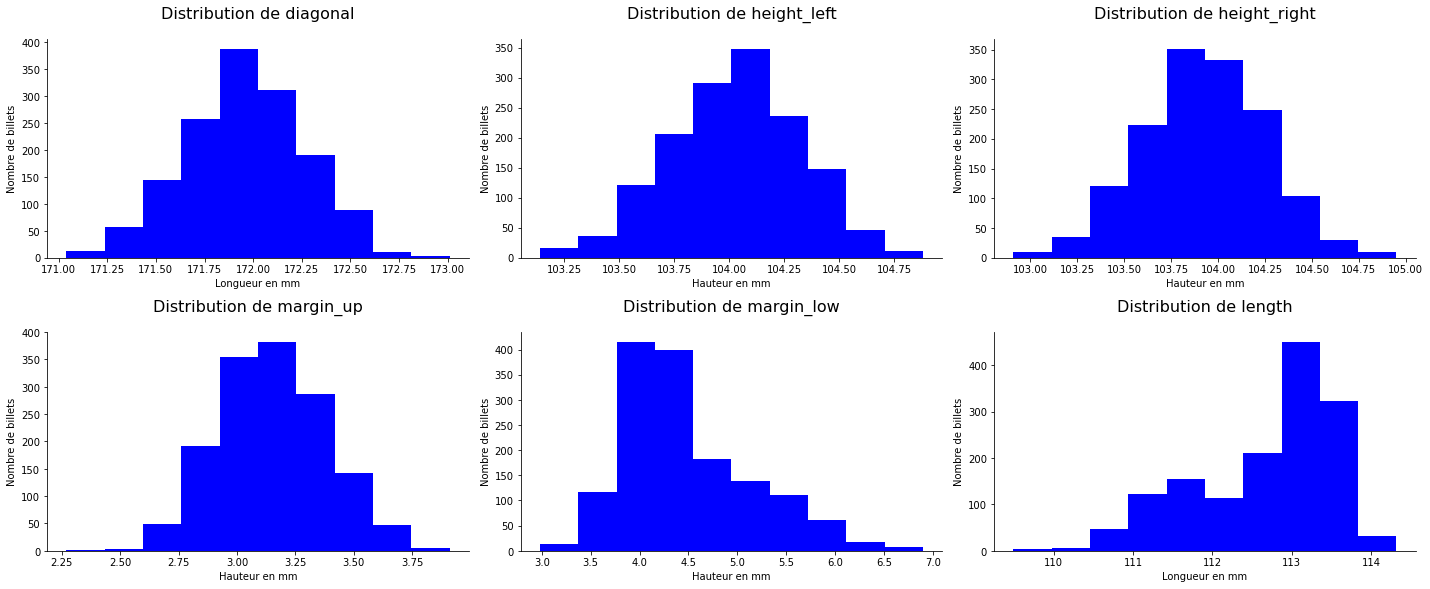

In [15]:
# Afficher la distribution de chaque varibale

plt.figure(figsize=(20,16))

plt.subplot(4,3,1)
ax = df_without_nan['diagonal'].hist(color='blue')
plt.title('Distribution de diagonal', fontsize=16, pad=20)
plt.xlabel('Longueur en mm')
plt.ylabel('Nombre de billets')
plt.grid(False)
ax.spines[['top', 'right']].set_visible(False)

plt.subplot(4,3,2)
ax = df_without_nan['height_left'].hist(color='blue')
plt.title('Distribution de height_left', fontsize=16, pad=20)
plt.xlabel('Hauteur en mm')
plt.ylabel('Nombre de billets')
plt.grid(False)
ax.spines[['top', 'right']].set_visible(False)

plt.subplot(4,3,3)
ax = df_without_nan['height_right'].hist(color='blue')
plt.title('Distribution de height_right', fontsize=16, pad=20)
plt.xlabel('Hauteur en mm')
plt.ylabel('Nombre de billets')
plt.grid(False)
ax.spines[['top', 'right']].set_visible(False)

plt.subplot(4,3,4)
ax = df_without_nan['margin_up'].hist(color='blue')
plt.title('Distribution de margin_up', fontsize=16, pad=20)
plt.xlabel('Hauteur en mm')
plt.ylabel('Nombre de billets')
plt.grid(False)
ax.spines[['top', 'right']].set_visible(False)

plt.subplot(4,3,5)
ax = df_without_nan['margin_low'].hist(color='blue')
plt.title('Distribution de margin_low', fontsize=16, pad=20)
plt.xlabel('Hauteur en mm')
plt.ylabel('Nombre de billets')
plt.grid(False)
ax.spines[['top', 'right']].set_visible(False)

plt.subplot(4,3,6)
ax = df_without_nan['length'].hist(color='blue')
plt.title('Distribution de length', fontsize=16, pad=20)
plt.xlabel('Longueur en mm')
plt.ylabel('Nombre de billets')
plt.grid(False)
ax.spines[['top', 'right']].set_visible(False)

plt.subplots_adjust(hspace=1)
plt.tight_layout()
plt.show()

<div style='background-color: white; padding: 20px'>
<p style='color: black'>Les variables 'diagonal', 'height_left', 'height_right' et 'margin_up' semblent suivre une distribution normale. <br>La variable 'margin_low' a une distribution étirée à droite tandis que celle de 'length' est étirée à gauche.</p>
</div>

In [16]:
# Fonction qui utilise le test de Shapiro-Wilk de scipy.stats pour tester la normalité des distributions
def Shap_Wilk(df, alpha=0.05):
    for index, column in enumerate(df.columns):
        sw_statistic, sw_p_value = stats.shapiro(df[column])
        if sw_p_value > alpha:
                print(f'Test de Shapiro-Wilk: la variable {column} semble suivre une gaussienne (on ne rejette pas H0)')
        else:
            print(f'Test de Shapiro-Wilk: la variable {column} ne semble pas suivre une gaussienne (on rejette H0)')
        print('-----------------------------------------')
        
        
Shap_Wilk(df_without_nan, alpha=0.05)

Test de Shapiro-Wilk: la variable is_genuine ne semble pas suivre une gaussienne (on rejette H0)
-----------------------------------------
Test de Shapiro-Wilk: la variable diagonal semble suivre une gaussienne (on ne rejette pas H0)
-----------------------------------------
Test de Shapiro-Wilk: la variable height_left semble suivre une gaussienne (on ne rejette pas H0)
-----------------------------------------
Test de Shapiro-Wilk: la variable height_right semble suivre une gaussienne (on ne rejette pas H0)
-----------------------------------------
Test de Shapiro-Wilk: la variable margin_low ne semble pas suivre une gaussienne (on rejette H0)
-----------------------------------------
Test de Shapiro-Wilk: la variable margin_up ne semble pas suivre une gaussienne (on rejette H0)
-----------------------------------------
Test de Shapiro-Wilk: la variable length ne semble pas suivre une gaussienne (on rejette H0)
-----------------------------------------


<Figure size 720x576 with 0 Axes>

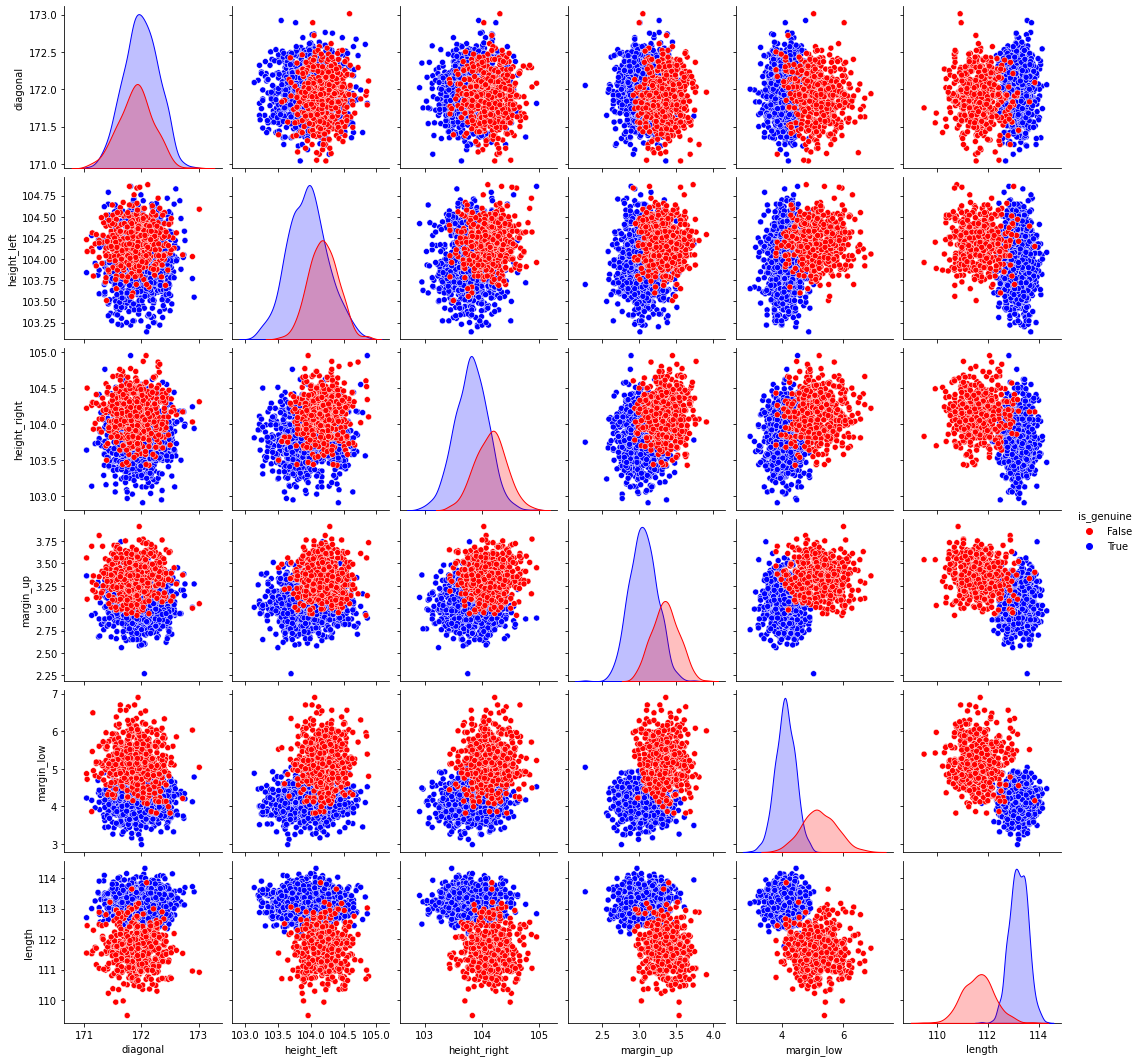

In [17]:
# Afficher un nuage de point pour chaque paire de variables de façon à visualiser les variables linéairement corrélées à margin_low
plt.figure(figsize=(10,8))
palette = ['red', 'blue']
sns.pairplot(df_without_nan, vars=['diagonal', 'height_left', 'height_right',
       'margin_up', 'margin_low', 'length'], hue='is_genuine', palette=palette)
plt.show()

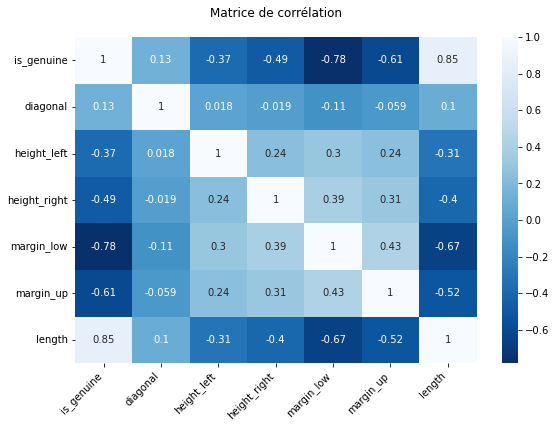

In [18]:
# Afficher la matrice de corrélation à l'aide d'une heatmap
plt.figure(figsize=(9,6))
sns.heatmap(df_without_nan.corr(), cmap='Blues_r', annot=True)
plt.title("Matrice de corrélation", fontweight=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

<div style='background-color: white; padding: 20px'>
<p style='color: black'>Si l'on fait abstraction de la variable is_genuine (qui est catégorielle), <b>il semblerait que "length" et (dans une moindre mesure) "margin_up", "height_right" et "height_left" soient les seules variables à avoir un semblant de relation linéaire avec "margin_low"</b>. <br><br>Testons la significativité de ces 4 relations.</p>
</div>

In [19]:
# Créer une fonction qui renvoie le coefficient de corrélation de Pearson et la p-valeur associée (qui mesure la significativité du coefficient)
def pearson_correlation_test(df, df_x, df_y):
    n = len(df[df_x])
    x_mean = df[df_x].mean()
    y_mean = df[df_y].mean()
    x_standard_deviation = df[df_x].std()
    y_standard_deviation = df[df_y].std()
    covariance_x_y = ((df[df_x] - x_mean) * (df[df_y] - y_mean)).sum() / len(df)
    pearson_coef = covariance_x_y / (x_standard_deviation * y_standard_deviation)
    
    # calcul de la statistique t utilisée pour calculer la p-valeur
    t_statistic = pearson_coef * np.sqrt((n-2)/(1-pearson_coef**2))
    
    # Calcul de la p-valeur associée au test, à comparer au seuil de signification (0.05)
    # Le test t de Student est bilatéral car le coefficient de Pearson, compris entre -1 et 1, peut être positif ou négatif
    p_value_two_sided = 2 * (1 - stats.t.cdf(abs(t_statistic), n - 2))
    return f'Coefficient de corrélation de Pearson: {round(pearson_coef,3)}, p-valeur: {p_value_two_sided}'

In [20]:
# tester le coefficient de corrélation de Pearson entre height_right et margin_low
pearson_correlation_test(df_without_nan, 'height_right', 'margin_low')

'Coefficient de corrélation de Pearson: 0.391, p-valeur: 0.0'

In [21]:
# tester le coefficient de corrélation de Pearson entre margin_up et margin_low
pearson_correlation_test(df_without_nan, 'margin_up', 'margin_low')

'Coefficient de corrélation de Pearson: 0.431, p-valeur: 0.0'

In [22]:
# tester le coefficient de corrélation de Pearson entre length et margin_low
pearson_correlation_test(df_without_nan, 'length', 'margin_low')

'Coefficient de corrélation de Pearson: -0.666, p-valeur: 0.0'

In [23]:
# tester le coefficient de corrélation de Pearson entre height_left et margin_low
pearson_correlation_test(df_without_nan, 'height_left', 'margin_low')

'Coefficient de corrélation de Pearson: 0.302, p-valeur: 0.0'

<div style='background-color: white; padding: 20px'>
<h3 style='color: blue; fontweight: bold'>Étape 1.3 - Train test split</h3>
</div>

In [24]:
# Séparer la variable cible des variables explicatives
y = df_without_nan.iloc[:,0]
X = df_without_nan.iloc[:,1:]

# Afficher la variable cible
y

0        True
1        True
2        True
3        True
4        True
        ...  
1495    False
1496    False
1497    False
1498    False
1499    False
Name: is_genuine, Length: 1463, dtype: bool

In [25]:
# Afficher les variables explicatives
X.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54


In [26]:
# Train Test split
# Nous avons de vrais billets dans les 1000 premières lignes et des faux dans les 500 dernières...
# mais la fonction train_test_split se charge de mélanger les données (shuffle = True par défaut)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

# Afficher les dimensions des sous-ensembles
print(f'Dimensions de X_train : {X_train.shape}')
print(f'Dimensions de X_test : {X_test.shape}')
print(f'Dimensions de y_train : {y_train.shape}')
print(f'Dimensions de y_test : {y_test.shape}')

Dimensions de X_train : (1170, 6)
Dimensions de X_test : (293, 6)
Dimensions de y_train : (1170,)
Dimensions de y_test : (293,)


In [27]:
# Fusionner X_train et y_train
df_train = X_train.merge(y_train.to_frame(), left_index=True, right_index=True)

# Nous avons à présent des vrais et des faux billets dans les premières lignes de df_train
# les données ont donc été mélangées comme prévu
df_train.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine
893,172.20,103.52,103.78,3.66,3.40,113.35,True
1071,171.50,103.90,103.98,4.82,3.40,112.07,False
260,172.27,103.71,103.64,4.64,2.67,113.63,True
1097,172.51,104.43,104.17,5.11,3.08,111.70,False
1224,171.74,104.52,104.23,5.59,3.61,112.14,False


In [28]:
# Fusionner X_test et y_test
df_test= X_test.merge(y_test.to_frame(), left_index=True, right_index=True)

In [29]:
# S'assurer que les données ont été mélangées dans l'ensemble de test
# Nous avons bien des vrais billets et des faux dans les 10 premières lignes du dataframe df_test
df_test.head(10)

,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine
1208,171.96,104.38,103.82,5.19,3.32,111.68,False
178,171.79,104.57,104.04,4.26,3.15,113.46,True
281,171.99,103.90,104.21,4.18,3.07,113.01,True
561,172.25,103.71,103.97,3.93,3.00,113.38,True
891,172.16,103.63,103.59,4.25,3.38,113.58,True
942,172.10,104.17,103.78,4.61,2.84,113.35,True
1018,171.79,104.18,103.87,5.55,3.25,111.88,False
899,172.39,103.98,104.05,4.26,2.98,113.41,True
756,171.72,103.95,104.11,3.75,3.13,113.51,True
920,171.85,103.27,103.96,4.00,2.65,113.62,True


<div style='background-color: white; padding: 20px'>
<h3 style='color: blue; fontweight: bold'>Etape 1.4 - Hypothèses de la régression linéaire</h3>
</div>

<div style='background-color: white; padding: 20px'>
<p style='color: black'>Pour chaque régression linéaire qui va suivre, on admet les hypothèses supposées ou vérifiées suivantes:<br><br><b>- Il existe une relation linéaire entre la variable explicative et la variable expliquée</b></br><br><b>- Les observations du jeu de données sont indépendantes</b>. Pour vérifier cette hypothèse, On utilisera le nuage de points qui montre la relation entre les résidus et les prédictions issus de la régression effectuée sur l'ensemble de test.</br><br><b>- Les résidus issus de la régression suivent une loi normale</b></br><br>Ensuite, il nous faudra tester la significativé du coefficient de la variable explicative, savoir s'il est significativement différent de 0, ce qui nous amène à deux nouvelles hypothèses:<br><br><b>H0: Le coefficient est = 0, et donc la variable associée n'a aucun pouvoir explicatif. <br>H1 : Le coefficient est significativement différent de 0, et donc la variable associée a un pouvoir explicatif plus ou moins important.</b></p>
</div>

<div style='background-color: white; padding: 20px'>
<h3 style='color: blue; fontweight: bold'>Etape 1.5 - Effectuer une régression linéaire simple</h3>
</div>

In [30]:
# Créer une fonction régression linéaire

def simple_linear_regression(df_train, df_test, dependent_variable, independent_variable):
    
    ''' 
    Paramètres:
    dependent_variable: variable cible, string type, 
    independent_variable: variable explicative, string type
    '''
    # Calculer la moyenne des deux variables sur l'ensemble de test
    dependent_variable_mean = df_test[dependent_variable].mean()
    independent_variable_mean = df_test[independent_variable].mean()
    
    # Effectuer la régression linéaire sur l'ensemble d'entraînement
    linear_reg = smf.ols(f"{dependent_variable} ~ {independent_variable}", data=df_train).fit()
    
    # Effectuer les prédictions sur l'ensemble de test
    predictions = linear_reg.predict(df_test)
    
    # si la variable indépendante est de type int ou float alors:
    if isinstance(df_test[independent_variable].iloc[0], (int, float)): 
        print()
        print('------ Visualiser le nuage de points et la droite de régression ------')
        plt.figure(figsize=(12, 9))
        plt.scatter(df_test[independent_variable], df_test[dependent_variable], color='blue', label="Données observées dans l'ensemble de test")
        # Prédictions pour l'ensemble de test
        plt.plot(df_test[independent_variable], predictions, color='red', label='Droite de régression')
        plt.scatter(independent_variable_mean, dependent_variable_mean, color='orange', label='Centre de gravité du nuage', s=100)
        plt.xlabel(independent_variable)
        plt.ylabel(dependent_variable)
        plt.title(f'La variable cible {dependent_variable} régressée par {independent_variable}', fontsize=16, fontweight='bold', pad=20)
        sns.despine()
        plt.legend()
        plt.show()
        
        # Afficher le résumé de la régression
        print(linear_reg.summary())
        
        # Récupérer les résidus
        residuals = linear_reg.resid
        
        print('------ Visualiser l\'allure de la distribution des résidus ------')
        fig, ax = plt.subplots(figsize=(12, 9))
        sns.histplot(residuals, color='blue', kde=True)
        plt.title('Distribution des résidus', fontsize=16,  fontweight='bold', pad=20)
        plt.xlabel('Résidus')
        plt.ylabel('Fréquence')
        sns.despine()
        plt.show()
        
        # Tester l'homoscédasticité des résidus
        print("------ Visualiser les résidus vs la variable indépendante ------")
        plt.figure(figsize=(12, 9))
        plt.scatter(df_train[independent_variable], residuals, color='red')
        plt.xlabel(independent_variable)
        plt.ylabel('Résidus en mm')
        plt.title(f'Répartition des résidus en fonction de {independent_variable}', fontsize=16, fontweight='bold', pad=20)
        sns.despine()
        plt.legend()
        plt.show()
        
        # Vérifier si les index des observations de df_test et de predictions correspondent
        print()
        print("------ Comparer les index de df_test et de predictions ------")
        print()
        print("index de df_test")
        print(df_test[dependent_variable].index)
        print("index de predictions")
        print(predictions.index)
        print()
        
        # Récupérer les résidus issus de la régression sur l'ensemble de test
        test_residuals = df_test[dependent_variable] - predictions
        
         # Tester l'homoscédasticité des résidus
        print("------ Visualiser les résidus vs les prédictions ------")
        plt.figure(figsize=(12, 9))
        plt.scatter(predictions, test_residuals, color='red')
        plt.xlabel(f"Prédictions de {dependent_variable} en mm")
        plt.ylabel('Résidus en mm')
        plt.title(f'Répartition des résidus en fonction des prédictions', fontsize=16, fontweight='bold', pad=20)
        sns.despine()
        plt.legend()
        plt.show()
        
        # Test de Breusch-Pagan
        _, LM_p_value, _, _ = het_breuschpagan(residuals, linear_reg.model.exog)
        print('------ Test d\'homoscédasticité des résidus ------')
        print(f'P-valeur du test de Breusch-Pagan: {LM_p_value}')
        print()
        
    else:
            
        # Afficher le résumé de la régression
        print(linear_reg.summary())
    
        # Récupérer les résidus
        residuals = linear_reg.resid
        
        print()
        print('------ Visualiser l\'allure de la distribution des résidus ------')
        fig, ax = plt.subplots(figsize=(9, 6))
        sns.histplot(residuals, color='blue', kde=True)
        plt.title('Distribution des résidus', fontsize=16,  fontweight='bold', pad=20)
        plt.xlabel('Résidus')
        plt.ylabel('Fréquence')
        sns.despine()
        plt.show()
        
        # Tester l'homoscédasticité des résidus
        _, LM_p_value, _, _ = het_breuschpagan(residuals, linear_reg.model.exog)
        print('------ Test d\'homoscédasticité des résidus ------')
        print(f'P-valeur du test de Breusch-Pagan: {LM_p_value}')
        print()
    


------ Visualiser le nuage de points et la droite de régression ------


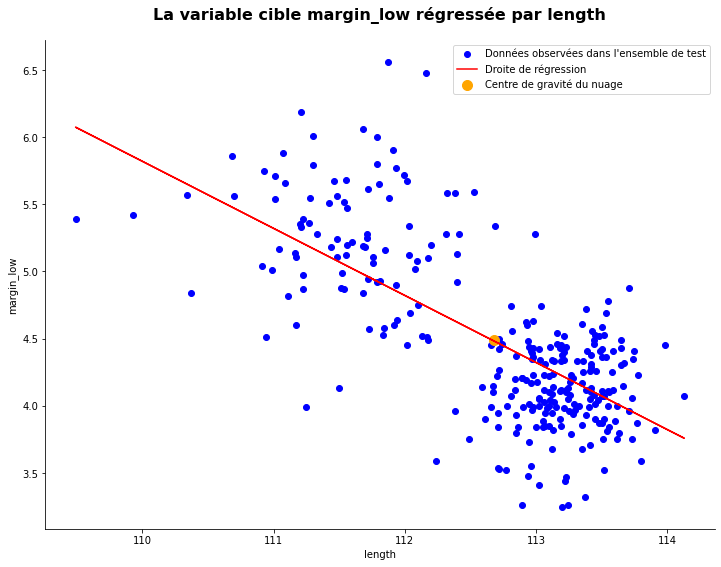

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     874.1
Date:                Mon, 26 Aug 2024   Prob (F-statistic):          7.17e-144
Time:                        10:54:13   Log-Likelihood:                -859.74
No. Observations:                1170   AIC:                             1723.
Df Residuals:                    1168   BIC:                             1734.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     60.7050      1.902     31.922      0.0

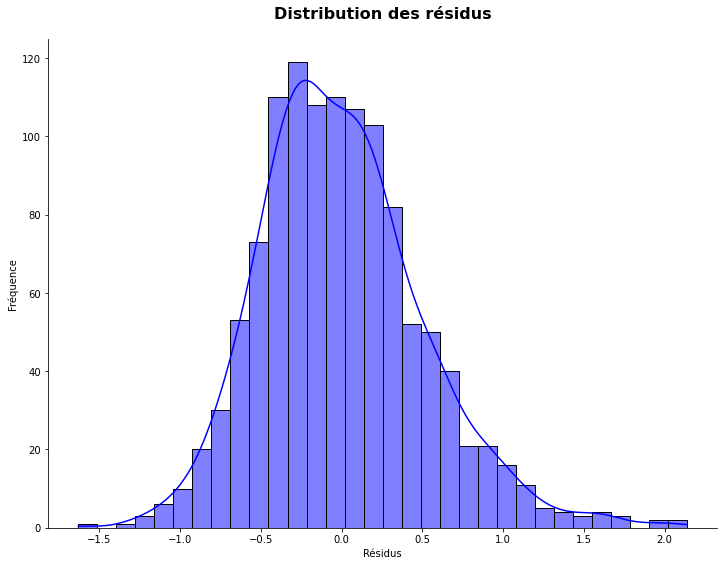

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


------ Visualiser les résidus vs la variable indépendante ------


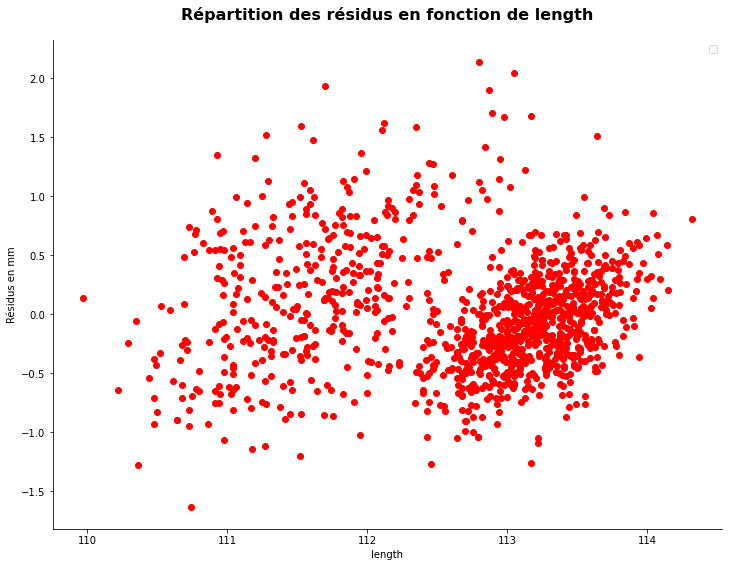

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



------ Comparer les index de df_test et de predictions ------

index de df_test
Int64Index([1208,  178,  281,  561,  891,  942, 1018,  899,  756,  920,
            ...
            1248, 1488, 1019,  721,  616, 1491,  493,  494, 1080, 1326],
           dtype='int64', length=293)
index de predictions
Int64Index([1208,  178,  281,  561,  891,  942, 1018,  899,  756,  920,
            ...
            1248, 1488, 1019,  721,  616, 1491,  493,  494, 1080, 1326],
           dtype='int64', length=293)

------ Visualiser les résidus vs les prédictions ------


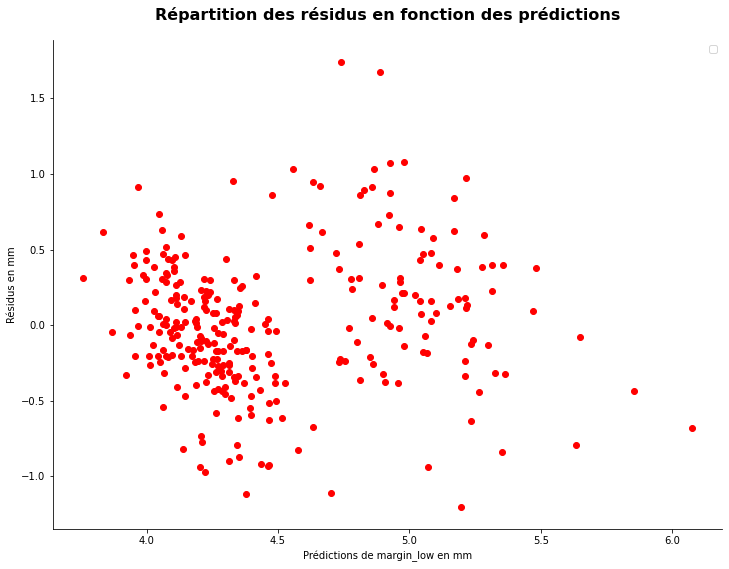

------ Test d'homoscédasticité des résidus ------
P-valeur du test de Breusch-Pagan: 1.5755002307903877e-12



In [31]:
# Effectuer une régression linéaire simple en utilisant la variable explicative length
simple_linear_regression(df_train, df_test, 'margin_low', 'length')

<div style='background-color: white; padding: 20px'>
<p style='color: black'>Le coefficient de détermination <b>R²</b> nous indique que la variable "length" explique 45 % de la variance de la variable cible 'margin_low'. La variable "length" est statistiquement significative puisque la P-valeur associée au test est inférieure au seuil de signification (0.05 soit 5 %). Plus précisément, c'est <b style='color: red'>le coefficient de la variable length qui est significativement différent de 0, ce qui confère à cette variable son pouvoir explicatif</b>.<br><br>L'estimation du coefficient de length est de -0.499 ; la margin_low d'un billet diminue de 0.499 mm lorsque sa longueur s'accroît d'un mm. Nous pouvons affirmer, avec un niveau de confiance de 95%, que ce coefficient se trouve dans l'intervalle de confiance compris entre -0.532 et -0.466.<br><br>On constate également que la distribution des résidus est à peu près symétrique / normale. <br><br>Concernant l'homoscédascticité des résidus, si en observant les nuages de points rouges ci-dessus celle-ci semble respectée, les résultats du test de Breusch-Pagan nous indiquent une violation de cette condition. Je vais me fier aux graphiques.<br><br> Essayons la régression avec les 2 autres variables.</p>
</div>

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     1751.
Date:                Mon, 26 Aug 2024   Prob (F-statistic):          1.40e-234
Time:                        10:54:14   Log-Likelihood:                -650.69
No. Observations:                1170   AIC:                             1305.
Df Residuals:                    1168   BIC:                             1316.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.2072      0

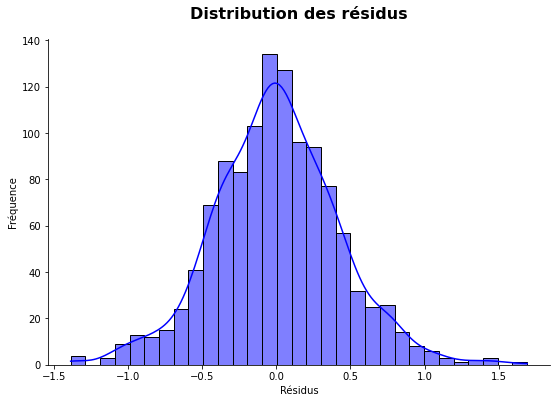

------ Test d'homoscédasticité des résidus ------
P-valeur du test de Breusch-Pagan: 1.7951403343096245e-34



In [32]:
# Effectuer une régression linéaire simple en utilisant la variable explicative is_genuine
simple_linear_regression(df_train, df_test, 'margin_low', 'is_genuine')

<div style='background-color: white; padding: 20px'>
<p style='color: black'>Le coefficient de détermination <b>R²</b> est plus élevé avec la variable "is_genuine" et le pouvoir explicatif de cette dernière est plus grand que celui de "length" et statistiquement significatif puisque la p-valeur est inférieure à 0.05. Les résidus sont normalement distribués mais, à nouveau, l'hypothèse d'homoscédasticité des résidus est violée.<br><br>A présent, effectuons une régression linéaire multiple.</p>
</div>

<div style='background-color: white; padding: 20px'>
<h3 style='color: blue; fontweight: bold'>Etape 1.6 - Effectuer une régression linéaire multiple</h3>
</div>

<div style='background-color: white; padding: 20px'>
<p style='color: black'>Les hypothèses de la régression linéaire simple (énumérées plus haut) s'appliquent à la régression multiple</p>
</div>

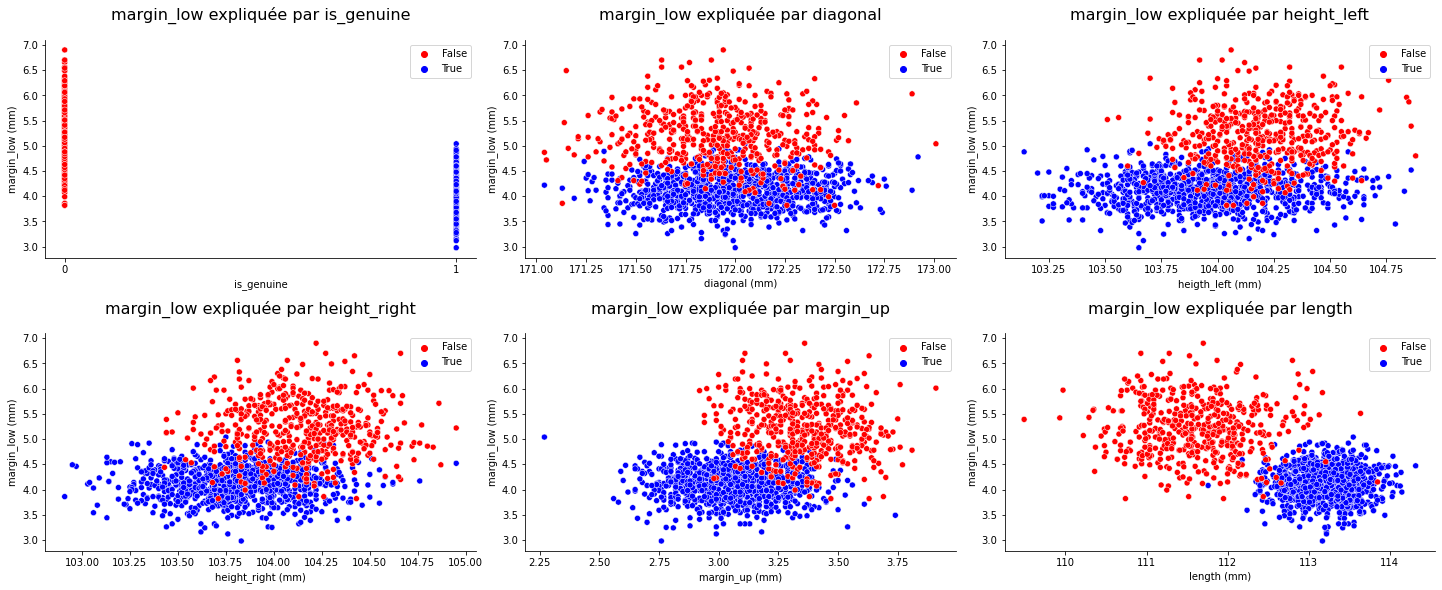

In [33]:
# Visualiser les relations entre chaque variable explicative et la variable cible
plt.figure(figsize=(20, 16))
palette = ['red', 'blue']
plt.subplot(4,3,1)
sns.scatterplot(x='is_genuine', y='margin_low', data=df_without_nan, hue='is_genuine', palette=palette)
plt.title('margin_low expliquée par is_genuine', fontsize=16, pad=20)
plt.xlabel('is_genuine')
plt.xticks(np.arange(0, 2))
plt.ylabel('margin_low (mm)')
plt.legend()

plt.subplot(4,3,2)
sns.scatterplot(x='diagonal', y='margin_low', data=df_without_nan, hue='is_genuine', palette=palette)
plt.title('margin_low expliquée par diagonal', fontsize=16, pad=20)
plt.xlabel('diagonal (mm)')
plt.ylabel('margin_low (mm)')
plt.legend()

plt.subplot(4,3,3)
sns.scatterplot(x='height_left', y='margin_low', data=df_without_nan, hue='is_genuine', palette=palette)
plt.title('margin_low expliquée par height_left', fontsize=16, pad=20)
plt.xlabel('heigth_left (mm)')
plt.ylabel('margin_low (mm)')
plt.legend()

plt.subplot(4,3,4)
sns.scatterplot(x='height_right', y='margin_low', data=df_without_nan, hue='is_genuine', palette=palette)
plt.title('margin_low expliquée par height_right', fontsize=16, pad=20)
plt.xlabel('height_right (mm)')
plt.ylabel('margin_low (mm)')
plt.legend()

plt.subplot(4,3,5)
sns.scatterplot(x='margin_up', y='margin_low', data=df_without_nan, hue='is_genuine', palette=palette)
plt.title('margin_low expliquée par margin_up', fontsize=16, pad=20)
plt.xlabel('margin_up (mm)')
plt.ylabel('margin_low (mm)')
plt.legend()

plt.subplot(4,3,6)
sns.scatterplot(x='length', y='margin_low', data=df_without_nan, hue='is_genuine', palette=palette)
plt.title('margin_low expliquée par length', fontsize=16, pad=20)
plt.xlabel('length (mm)')
plt.ylabel('margin_low (mm)')
plt.legend()

plt.subplots_adjust(hspace=1)
plt.tight_layout()
sns.despine()
plt.show()

In [34]:
# Afficher la matrice de corrélation
df_without_nan.corr()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,1.000000,0.134720,-0.373624,-0.487177,-0.783032,-0.610412,0.850223
diagonal,0.134720,1.000000,0.018265,-0.019428,-0.111534,-0.059147,0.100758
height_left,-0.373624,0.018265,1.000000,0.235132,0.302643,0.243812,-0.314344
height_right,-0.487177,-0.019428,0.235132,1.000000,0.391085,0.306867,-0.404272
margin_low,-0.783032,-0.111534,0.302643,0.391085,1.000000,0.431606,-0.666753
margin_up,-0.610412,-0.059147,0.243812,0.306867,0.431606,1.000000,-0.521139
length,0.850223,0.100758,-0.314344,-0.404272,-0.666753,-0.521139,1.000000


<div style='background-color: white; padding: 20px'>
<p style='color: black'>Comme évoqué plus haut, "is_genuine" et "length", et dans une moindre mesure "margin_up" et "height_right", sont les variables les plus corrélées à la variable cible "margin_low". <br><br>Quant à "height_left" et "diagonal", <b>on peut d'ores et déjà les exclure </b>(relation linéaire inexistante ou insuffisante avec margin_low, coefficients de corrélation de -0.11 et 0.30 respectivement). <br><br> <b style='color: red'>On remarque également que is_genuine et length sont fortement corrélées, ce qui pourrait causer des problèmes de multicolinéarité, autrement dit de la redondance dans l'explication de la variance de margin_low. Il nous faudra peut-être exclure l'une des deux, en particulier si leur VIF est supérieur à 5</b>.</p>
</div>

In [35]:
# Fonction qui va effectuer plusieurs fois une régression linéaire multiple 
# ...et progressivement éliminer les variables restantes qui ne sont pas statistiquement significatives

def multiple_regression_backward_selected(df_train, dependent_variable):
    """Linear model designed by backward selection.

    Parameters:
    -----------
    df : pandas dataFrame with all possible predictors and dependent_variable

    dependent_variable: string, name of dependent_variable column in df

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by backward selection
           evaluated by parameters p-value
    """

    remaining = set(df_train._get_numeric_data().columns)
    if dependent_variable in remaining:
        remaining.remove(dependent_variable)
    cond = True

    while remaining and cond:
        formula = "{} ~ {} + 1".format(dependent_variable,' + '.join(remaining))
        print('_______________________________')
        print(formula)
        multiple_reg_model = smf.ols(formula, df_train).fit()
        print(multiple_reg_model.summary())
        
        # # Jauger les éventuels problèmes de colinéarité
        # variables = multiple_reg_model.model.exog
        # VIF = [variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]
        # print(VIF)
        
        # Récupérer la p-valeur de chaque variable...
        score = multiple_reg_model.pvalues[1:]
        
        # ...puis supprimer la variable qui a la p-valeur la plus élevée
        # si cette dernière est supérieure à 0.05 (seuil de signification de 5%)
        toRemove = score[score == score.max()]
        if toRemove.values > 0.05:
            print('remove', toRemove.index[0], '(p-value :', round(toRemove.values[0],3), ')')
            remaining.remove(toRemove.index[0])
        else:
            cond = False
            print('is the final model !')
        print('')
   
    # Afficher les résultats de la régression multiple
    print(multiple_reg_model.summary())
    
    # Récupérer les résidus
    residuals = multiple_reg_model.resid
    
    print()
    print('***** Visualiser l\'allure de la distribution des résidus *****')
    fig, ax = plt.subplots(figsize=(9, 6))
    sns.histplot(residuals, color='blue', kde=True)
    plt.title('Distribution des résidus')
    plt.xlabel('Résidus')
    plt.ylabel('Fréquence')
    plt.show()
    
    # Tester l'homoscédasticité des résidus
    _, LM_p_value, _, _ = het_breuschpagan(residuals, multiple_reg_model.model.exog)
    print('------ Test d\'homoscédasticité des résidus ------')
    print(f'P-valeur du test de Breusch-Pagan: {LM_p_value}')
    
    # Jauger les éventuels problèmes de colinéarité
    variables = multiple_reg_model.model.exog
    # Si le VIF est inférieur à 5, on considère que l'éventuelle multicolinéarité ne pose pas de problème
    # Si le VIF est compris entre 5 et 10, l'éventuelle multicolinéarité pourrait poser problème
    # Si le VIF est supérieur à 10, l'estimation des coefficients est fortement biaisée par la multicolinéarité...
    # ... rendant ces coefficients inutilisables
    print()
    print('------ VIF des variables explicatives restantes ------')
    VIF = [variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]
    print(VIF)
    print()
    
      # Analyser l'atypicité et l'influence des observations
    print("------ Atypicité et influence des observations ------")
    n = df_train[dependent_variable].count()
    p = df_train.shape[1]
    
    influences = multiple_reg_model.get_influence()
    summary_fr = influences.summary_frame()
    print(summary_fr)
    hii = summary_fr['hat_diag']
    atypical_indices = []
    for i, value in enumerate(hii):
        if value > 2 * p / n:
            atypical_indices.append(summary_fr.index[i])
    print("Observations atypiques:")
    print(atypical_indices)
    

    cooks_distance = summary_fr['cooks_d']
    influent_indices = []
    for i, value in enumerate(cooks_distance):
        if value > 4 / (n-p):
            influent_indices.append(summary_fr.index[i])
    print(" Observations influentes:")
    print(influent_indices)
    
    outliers_indices = []
    for i in df_train.index:
        if i in atypical_indices and i in influent_indices:
            outliers_indices.append(i)

    
    return multiple_reg_model, outliers_indices

_______________________________
margin_low ~ height_right + is_genuine + length + margin_up + 1
                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     442.4
Date:                Mon, 26 Aug 2024   Prob (F-statistic):          6.80e-232
Time:                        10:54:17   Log-Likelihood:                -646.11
No. Observations:                1170   AIC:                             1302.
Df Residuals:                    1165   BIC:                             1328.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

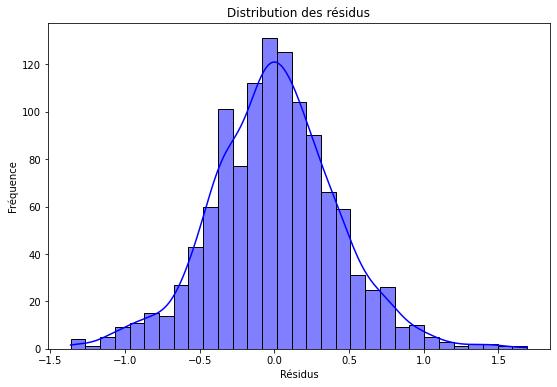

------ Test d'homoscédasticité des résidus ------
P-valeur du test de Breusch-Pagan: 1.1912050767104977e-32

------ VIF des variables explicatives restantes ------
[1.6409829916476797, 1.6409829916476788]

------ Atypicité et influence des observations ------
      dfb_Intercept  dfb_is_genuine[T.True]  dfb_margin_up   cooks_d  \
893        0.051124               -0.047068      -0.051348  0.001242   
1071       0.001612                0.025128      -0.005872  0.000697   
260        0.064469               -0.022992      -0.064752  0.001891   
1097      -0.017954                0.021874       0.016308  0.000202   
1224      -0.036332               -0.007138       0.041364  0.001470   
...             ...                     ...            ...       ...   
1161       0.049668               -0.066179      -0.044191  0.001880   
1328       0.001620               -0.003003      -0.001304  0.000005   
884        0.000528                0.005607      -0.000530  0.000057   
1496       0.000461 

In [36]:
# Utiliser la fonction ci-dessus pour effectuer la régression multiple
# Exclure au préalables les variables height_left et diagonal
multiple_reg_variables = ['height_right', 'margin_low', 'margin_up', 'length', 'is_genuine']
multiple_reg, outlier_index_list = multiple_regression_backward_selected(df_train[multiple_reg_variables], 'margin_low')
multiple_reg

In [37]:
# Visualiser les outliers (observations qui sont à la fois atypiques et influentes)
outlier_index_list

[664, 1029, 52]

In [38]:
# Retirer les outliers
df_train = df_train.loc[~df_train.index.isin(outlier_index_list)]

# Vérifier
df_train.index.isin(outlier_index_list).sum()

0

_______________________________
margin_low ~ height_right + is_genuine + length + margin_up + 1
                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     442.1
Date:                Mon, 26 Aug 2024   Prob (F-statistic):          1.41e-231
Time:                        10:54:18   Log-Likelihood:                -641.22
No. Observations:                1167   AIC:                             1292.
Df Residuals:                    1162   BIC:                             1318.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

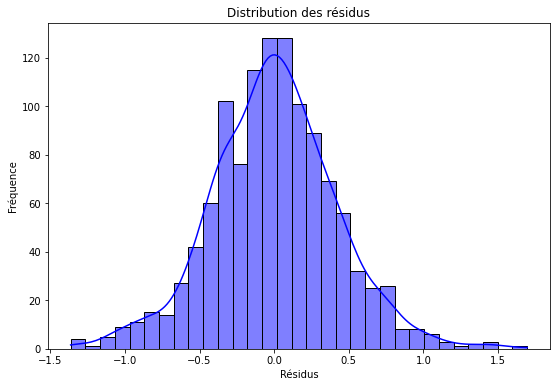

------ Test d'homoscédasticité des résidus ------
P-valeur du test de Breusch-Pagan: 1.3758856997860188e-32

------ VIF des variables explicatives restantes ------
[1.6563355365205068, 1.656335536520507]

------ Atypicité et influence des observations ------
      dfb_Intercept  dfb_is_genuine[T.True]  dfb_margin_up   cooks_d  \
893        0.052682               -0.048413      -0.052906  0.001306   
1071       0.001981                0.024756      -0.006170  0.000697   
260        0.066544               -0.024415      -0.066827  0.001997   
1097      -0.017547                0.021317       0.015978  0.000191   
1224      -0.037450               -0.006230       0.042417  0.001505   
...             ...                     ...            ...       ...   
1161       0.050743               -0.067412      -0.045278  0.001946   
1328       0.001835               -0.003397      -0.001483  0.000006   
884        0.000547                0.005607      -0.000550  0.000058   
1496       0.000426  

In [39]:
# Lancer une nouvelle régression multiple sans les outliers
multiple_reg, outlier_index_list = multiple_regression_backward_selected(df_train[multiple_reg_variables], 'margin_low')
multiple_reg

<div style='background-color: white; padding: 20px'>
<p style='color: black'>D'après les résultats ci-dessus, seules les variables is_genuine et margin_up sont satistiquement significatives car leurs p-valeurs associées sont inférieures au seuil de signification.</p>
</div>

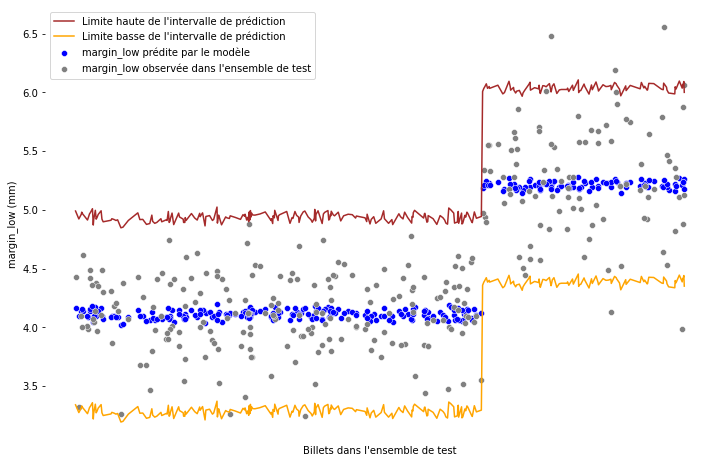

In [40]:
# Prédire la margin_low à partir de is_genuine et margin_up sur l'ensemble de test
# et afficher les intervalles de prédiction pour les billets qui s'y trouvent
variables = ['is_genuine', 'margin_up']
predictions = multiple_reg.predict(df_test[variables])
summary_frame = multiple_reg.get_prediction(df_test[variables]).summary_frame()

fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=summary_frame, x=predictions.index, y=summary_frame['obs_ci_upper'], color='brown', label="Limite haute de l'intervalle de prédiction")
sns.lineplot(data=summary_frame, x=predictions.index, y=summary_frame['obs_ci_lower'], color='orange', label="Limite basse de l'intervalle de prédiction")
sns.scatterplot(data=predictions, x=predictions.index, y=predictions, color='blue', label="margin_low prédite par le modèle")
sns.scatterplot(data=predictions, x=df_test["margin_low"].index, y=df_test["margin_low"], color='gray', label="margin_low observée dans l'ensemble de test")

plt.ylabel("margin_low (mm)")
plt.xlabel("Billets dans l'ensemble de test")
plt.xticks([])
ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)
plt.show()

In [41]:
# Afficher le R² du modèle sur l'ensemble de test
predictions = multiple_reg.predict(df_test[variables])

# Afficher le R² sur l'ensemble de test
r2 = r2_score(df_test['margin_low'], predictions)
mse = mean_squared_error(df_test['margin_low'], predictions)
rmse = np.sqrt(mse)
print("Coefficient de détermination (R²) sur l'ensemble de test :", r2)
print("Erreur quadratique moyenne sur l'ensemble de test :", mse)
print("Erreur type sur l'ensemble de test:", rmse)

Coefficient de détermination (R²) sur l'ensemble de test : 0.6733672157443473
Erreur quadratique moyenne sur l'ensemble de test : 0.13767746151333726
Erreur type sur l'ensemble de test: 0.3710491362519757


In [42]:
# Lister les index des valeurs manquantes
nan_indices = df.loc[df['margin_low'].isna()].index
nan_indices

Int64Index([  72,   99,  151,  197,  241,  251,  284,  334,  410,  413,  445,
             481,  505,  611,  654,  675,  710,  739,  742,  780,  798,  844,
             845,  871,  895,  919,  945,  946,  981, 1076, 1121, 1176, 1303,
            1315, 1347, 1435, 1438],
           dtype='int64')

In [43]:
# Effectuer les prédictions pour les lignes contenant des valeurs manquantes dans la colonne margin_low
df_pred = df.loc[df.index.isin(nan_indices)]
margin_low_preds = multiple_reg.predict(df_pred[variables])

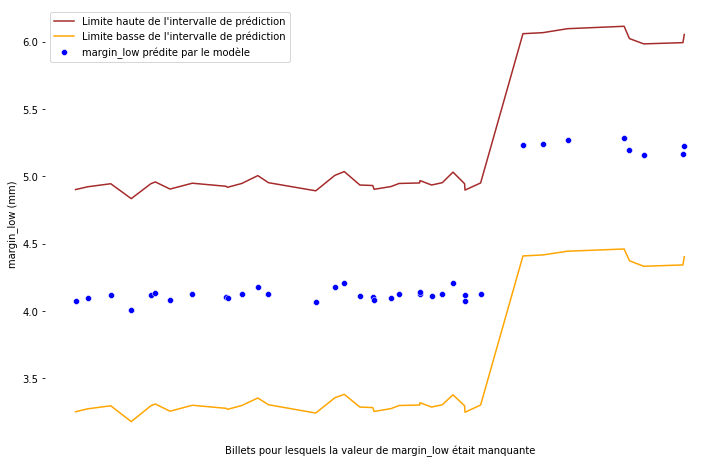

In [44]:
summary_frame = multiple_reg.get_prediction(df_pred[variables]).summary_frame()

fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=summary_frame, x=margin_low_preds.index, y=summary_frame['obs_ci_upper'], color='brown', label="Limite haute de l'intervalle de prédiction")
sns.lineplot(data=summary_frame, x=margin_low_preds.index, y=summary_frame['obs_ci_lower'], color='orange', label="Limite basse de l'intervalle de prédiction")
sns.scatterplot(data=margin_low_preds, x=margin_low_preds.index, y=margin_low_preds, color='blue', label="margin_low prédite par le modèle")
plt.ylabel("margin_low (mm)")
plt.xlabel("Billets pour lesquels la valeur de margin_low était manquante")
plt.xticks([])
ax.spines[['top', 'left', 'right', 'bottom']].set_visible(False)
plt.show()

<div style='background-color: white; padding: 20px'>
<h3 style='color: blue; fontweight: bold'>Étape 1.7 - Remplacer les valeurs manquantes par les prédictions de la régression multiple</h3>
</div>

In [45]:
# Afficher les 37 valeurs manquantes
df_nan = df.loc[df['margin_low'].index.isin(nan_indices)] 
df_nan

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36
251,True,171.80,103.26,102.82,NaN,2.95,113.22
284,True,171.92,103.83,103.76,NaN,3.23,113.29
334,True,171.85,103.70,103.96,NaN,3.00,113.36
410,True,172.56,103.72,103.51,NaN,3.12,112.95
413,True,172.30,103.66,103.50,NaN,3.16,112.95


In [46]:
# Remplacer les valeurs manquantes par les prédictions
df['margin_low'].fillna(margin_low_preds, inplace=True)

# Vérifier si le remplacement a été effectué
df.loc[df['margin_low'].index.isin(nan_indices)]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,4.076606,3.25,112.79
99,True,171.93,104.07,104.18,4.097537,3.14,113.08
151,True,172.07,103.80,104.38,4.120371,3.02,112.93
197,True,171.45,103.66,103.80,4.006201,3.62,113.27
241,True,171.83,104.14,104.06,4.120371,3.02,112.36
251,True,171.80,103.26,102.82,4.133691,2.95,113.22
284,True,171.92,103.83,103.76,4.080412,3.23,113.29
334,True,171.85,103.70,103.96,4.124177,3.00,113.36
410,True,172.56,103.72,103.51,4.101343,3.12,112.95
413,True,172.30,103.66,103.50,4.093731,3.16,112.95


In [47]:
# Nombre de nan dans la colonne margin_low
df['margin_low'].isna().sum()

0

<div style='background-color: white; padding: 20px'>
<p style='color: black'>D'après les statistiques (voir les toutes premières cellules de l'analyse exploratoire), la margin_low médiane est de 4.11 mm pour les vrais billets et de 5.19 mm pour les faux billets. On peut donc affirmer que les prédictions qui remplacent les NaN sont très proches de ce qui est attendu.</p>
</div>

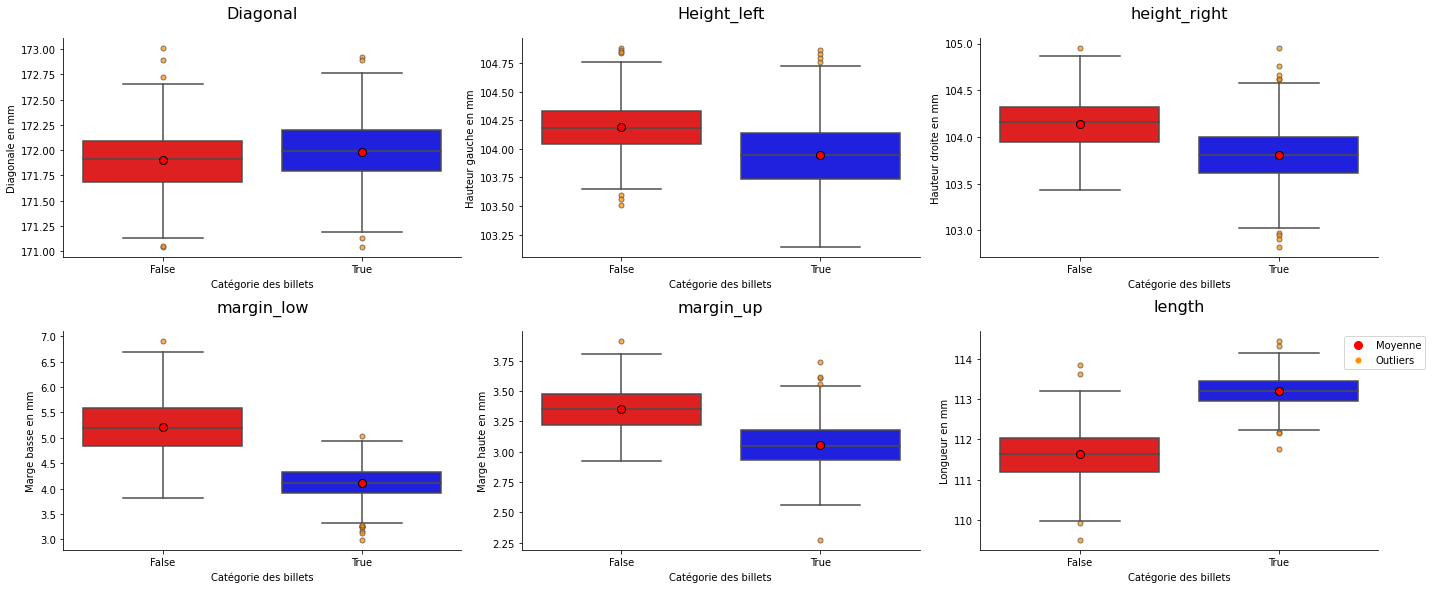

In [48]:
# Comparer les faux et les vrais billets à l'aide d'un boxplot
plt.figure(figsize=(20, 16))

palette = ['red', 'blue']

plt.subplot(4,3,1)
meanprops = dict(marker='o', markersize=8, markeredgecolor='black', markerfacecolor='red')
mean_marker = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=8, label='Moyenne')
flierprops = dict(marker='o', markersize=5, markerfacecolor='darkorange', linestyle='none', alpha=0.7)
outliers_marker = mlines.Line2D([], [], color='darkorange', marker='o', linestyle='None', markersize=5, label='Outliers')
sns.boxplot(x='is_genuine', y='diagonal', data=df, palette=palette, meanprops=meanprops, showmeans=True, flierprops=flierprops)
plt.title('Diagonal', fontsize=16, pad=20)
plt.xlabel('Catégorie des billets')
plt.ylabel('Diagonale en mm')

plt.subplot(4,3,2)
meanprops = dict(marker='o', markersize=8, markeredgecolor='black', markerfacecolor='red')
mean_marker = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=8, label='Moyenne')
flierprops = dict(marker='o', markersize=5, markerfacecolor='darkorange', linestyle='none', alpha=0.7)
outliers_marker = mlines.Line2D([], [], color='darkorange', marker='o', linestyle='None', markersize=5, label='Outliers')
sns.boxplot(x='is_genuine', y='height_left', data=df, palette=palette, meanprops=meanprops, showmeans=True, flierprops=flierprops)
plt.title('Height_left', fontsize=16, pad=20)
plt.xlabel('Catégorie des billets')
plt.ylabel('Hauteur gauche en mm')

plt.subplot(4,3,3)
meanprops = dict(marker='o', markersize=8, markeredgecolor='black', markerfacecolor='red')
mean_marker = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=8, label='Moyenne')
flierprops = dict(marker='o', markersize=5, markerfacecolor='darkorange', linestyle='none', alpha=0.7)
outliers_marker = mlines.Line2D([], [], color='darkorange', marker='o', linestyle='None', markersize=5, label='Outliers')
sns.boxplot(x='is_genuine', y='height_right', data=df, palette=palette, meanprops=meanprops, showmeans=True, flierprops=flierprops)
plt.title('height_right', fontsize=16, pad=20)
plt.xlabel('Catégorie des billets')
plt.ylabel('Hauteur droite en mm')

plt.subplot(4,3,4)
meanprops = dict(marker='o', markersize=8, markeredgecolor='black', markerfacecolor='red')
mean_marker = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=8, label='Moyenne')
flierprops = dict(marker='o', markersize=5, markerfacecolor='darkorange', linestyle='none', alpha=0.7)
outliers_marker = mlines.Line2D([], [], color='darkorange', marker='o', linestyle='None', markersize=5, label='Outliers')
sns.boxplot(x='is_genuine', y='margin_low', data=df, palette=palette, meanprops=meanprops, showmeans=True, flierprops=flierprops)
plt.title('margin_low', fontsize=16, pad=20)
plt.xlabel('Catégorie des billets')
plt.ylabel('Marge basse en mm')

plt.subplot(4,3,5)
meanprops = dict(marker='o', markersize=8, markeredgecolor='black', markerfacecolor='red')
mean_marker = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=8, label='Moyenne')
flierprops = dict(marker='o', markersize=5, markerfacecolor='darkorange', linestyle='none', alpha=0.7)
outliers_marker = mlines.Line2D([], [], color='darkorange', marker='o', linestyle='None', markersize=5, label='Outliers')
sns.boxplot(x='is_genuine', y='margin_up', data=df, palette=palette, meanprops=meanprops, showmeans=True, flierprops=flierprops)
plt.title('margin_up', fontsize=16, pad=20)
plt.xlabel('Catégorie des billets')
plt.ylabel('Marge haute en mm')

plt.subplot(4,3,6)
meanprops = dict(marker='o', markersize=8, markeredgecolor='black', markerfacecolor='red')
mean_marker = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=8, label='Moyenne')
flierprops = dict(marker='o', markersize=5, markerfacecolor='darkorange', linestyle='none', alpha=0.7)
outliers_marker = mlines.Line2D([], [], color='darkorange', marker='o', linestyle='None', markersize=5, label='Outliers')
sns.boxplot(x='is_genuine', y='length', data=df, palette=palette, meanprops=meanprops, showmeans=True, flierprops=flierprops)
plt.title('length', fontsize=16, pad=20)
plt.xlabel('Catégorie des billets')
plt.ylabel('Longueur en mm')

sns.despine()
plt.legend(handles=[mean_marker,outliers_marker], bbox_to_anchor=(0.90, 1), loc='upper left')
plt.subplots_adjust(hspace=1)
plt.tight_layout()
plt.show()


<div style='background-color: steelblue; padding: 20px'>
<h2 style='color: white; fontweight: bold'>Étape 2 - Régression logistique</h2>
</div>

<div style='background-color: white; padding: 20px'>
<h3 style='color: blue; fontweight: bold'>Étape 2.1 - Hypothèses de la régression logistique</h3>
</div>

<div style='background-color: white; padding: 20px'>
<p style='color: black'><b style='color: red'>Hypothèse fondamentale de la régression logistique:</b><br><br><b>- Logit(p) = Logit(p/1-p) = b0 + b1*x1</b><br><br><b style='color: red'>Autres hypothèses de la régression logistique</b> (supposées ou vérifiées):<br><br><b>- La variable cible est binaire; elle suit une loi de bernoulli de paramètre p</b>. C'est le cas puisque is_genuine ne peut prendre que deux valeurs; True ou False (1 ou 0).<br><br><b>- La taille du jeu de données est suffisante</b>. C'est le cas, nous avons 1500 individus.<br><br><b>- Les individus sont indépendants</b>. C'est le cas; le fait qu'un billet donné soit contrefait ou non n'influe pas sur l'authenticité d'un autre billet.<br><br><b>- Pas ou peu de multicolinéarité entre les variables explicatives utilisées</b>. Vérifiée lors de la régression linéaire multiple; aucun VIF ne dépasse 5</p>
</div>

<div style='background-color: white; padding: 20px'>
<h3 style='color: blue; fontweight: bold'>Étape 2.2 - Centrage et réduction + train test split</h3>
</div>

In [49]:
# Créer une fonction pour centrer et réduire les données
 # c'est à dire soustraire de chaque valeur la moyenne puis diviser chaque valeur centrée par l'écart type
def standardization(df):
   # Instancier un scaler
   scaler = StandardScaler()

    # Ajustement et transformation des données
   df_scaled = scaler.fit_transform(df)

    # Conversion du tableau numpy en dataframe
   df_scaled = pd.DataFrame(df_scaled, index=df.index, columns=df.columns)
    
   return df_scaled

In [50]:
# Séparer la variable cible des variables explicatives
y = df.iloc[:,0]
X = df.iloc[:,1:]

In [51]:
# Centrer et réduire les variables explicatives
X = standardization(X)

In [52]:
# Afficher les variables explicatives
X.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.486540,2.774123,3.163240,0.056462,-1.128325,0.173651
1,-1.633729,-2.236535,-0.799668,-1.080631,-0.696799,0.471666
2,2.397823,1.504756,-1.291191,-0.125473,-0.912562,0.551901
3,-1.961498,-0.399294,0.060498,-1.308050,-0.610494,0.953075
4,-0.748754,0.836669,-1.414072,-0.671278,1.417677,-0.158750


<div style='background-color: white; padding: 20px'>
<p style='color: black; fontweight: bold'>A présent, séparons le jeu de données en deux sous-ensembles:<br><br><b>-Un sous-ensemble d'entraînement qui représente 80% des données</b><br><b>-Un sous-ensemble de test qui représente les 20% restant</b> et sur lequel nous allons tester notre modèle de régression logistique, c'est à dire comparer les métriques obtenus sur l'ensemble de test à ceux obtenus sur l'ensemble d'entraînement.<br><br>Si les scores obtenus à l'entraînement sont significativement meilleurs qu'au test, il faut s'attendre à ce que le modèle souffre de surapprentissage.</p>
</div>

In [53]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

# Afficher les dimensions des sous-ensembles
print(f'Dimensions de X_train : {X_train.shape}')
print(f'Dimensions de X_test : {X_test.shape}')
print(f'Dimensions de y_train : {y_train.shape}')
print(f'Dimensions de y_test : {y_test.shape}')

Dimensions de X_train : (1200, 6)
Dimensions de X_test : (300, 6)
Dimensions de y_train : (1200,)
Dimensions de y_test : (300,)


In [54]:
# Afficher le nombre de vrais et de faux billets dans chaque sous-ensemble y
print('y_train:')
print(y_train.value_counts())
print('y_test:')
print(y_test.value_counts())

y_train:
True     810
False    390
Name: is_genuine, dtype: int64
y_test:
True     190
False    110
Name: is_genuine, dtype: int64


In [55]:
# Afficher X_train
X_train.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
382,1.053972,1.972418,-0.369585,-0.610633,-0.308426,0.666522
538,-0.191548,1.571565,-1.321911,-0.610633,-1.430393,0.941613
1493,-1.076523,1.003691,2.118753,0.602267,0.856694,-0.594311
1112,0.332882,0.836669,1.197146,1.709037,0.511473,-1.224728
324,0.463989,1.304330,-0.983989,-0.459020,-1.128325,0.735295


In [56]:
y_train.head()

382      True
538      True
1493    False
1112    False
324      True
Name: is_genuine, dtype: bool

<div style='background-color: white; padding: 20px'>
<h3 style='color: blue; fontweight: bold'>Étape 2.3 - Entraîner un dummy classifier</h3>
</div>

In [57]:
# L'accuracy score du dummy sera notre score repère / de base
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)  # on prédit la classe la plus fréquente à chaque fois
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
accuracy_score = dummy_clf.score(X_test, y_test)
print(accuracy_score )

0.6333333333333333


<div style='background-color: white; padding: 20px'>
<h3 style='color: blue; fontweight: bold'>Étape 2.4 - Entraîner un modèle de régression logistique</h3>
</div>

<div style='background-color: white; padding: 20px'>
<p style='color: black; fontweight: bold'>Nous allons utiliser <b style='color:red'>GridSearchCV</b> de scikit learn pour entraîner plusieurs modèles de régression logistique, choisir le modèle le plus performant et implémenter la validation croisée par la même occasion.</p>
</div>

In [58]:
# créer une fonction qui renvoie les scores du modèle à l'entrainement et au test
def scores(estimator):
    train_score = estimator.score(X_train, y_train).round(4)
    test_score = estimator.score(X_test, y_test).round(4)
    return f'Train score : {train_score} | Test score : {test_score}'

In [59]:
# Créer une fonction qui entraîne plusieurs modèles de régression logistique
# tout en implémentant la validation croisée

def GridSearchCV_Logistic_Regression(X_train, X_test, y_train, y_test, random_state, x_variable):
    
    '''
    random_state: nombre quelconque passé en paramètre pour la reproductibilité des résultats 
    x_variable: variable explicative à utiliser pour la visualisation nuage de point + courbe sigmoïde
    x_variable_coef_index: dictionnaire avec en clé le nom de la variable, en valeur l'index de la colonne
    '''
    warnings.filterwarnings('ignore')

    # Instancier un classifieur 
    classifier = LogisticRegression(random_state=random_state)

    parameters = [{'penalty': ['l1', 'l2'], 'solver': ['liblinear'], 'C': [1, 10, 100, 1000]}]
    
    grid_search = GridSearchCV(classifier, parameters, cv=5) 
    grid_search.fit(X_train, y_train)   

    # On récupère le modèle qui s'est montré le plus performant pendant la phase d'entraînement
    best_estimator = grid_search.best_estimator_
    
    coefs = best_estimator.coef_
    intercept = best_estimator.intercept_
    # print(coefs, intercept)
    
    # Effectuer des prédictions sur l'ensemble de test
    y_pred = best_estimator.predict(X_test)
    
    # Calculer les probabilités qu'un individu appartienne à la classe 0, à la classe 1
    y_pred_proba = best_estimator.predict_proba(X_test)[:,1]
    
    # Générer des valeurs z pour la courbe sigmoïde
    z_values = np.linspace(-3, 3, 300)
    
    # Index des coefficients
    x_variable_coef_index = {'diagonal':0, 'height_left':1, 'height_right':2, 'margin_low':3, 'margin_up':4, 'length':5} # !! codé en dur...

    # Calculer les probabilités à partir du coefficient de la variable explicative et de l'intercept
    # coefs[0][x_variable_coef_index[x_variable]] correspond au coefficient de la variable length
    sigmoid_probs = 1 / (1 + np.exp(-coefs[0][x_variable_coef_index[x_variable]]*z_values-intercept[0]))
    
    
    print(f"------ Visualiser le nuage de points et la courbe sigmoïde ------")
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.scatterplot(data=X_test, x=X_test[x_variable], y=y_test, color='blue')
    # Ajouter la courbe sigmoïde
    plt.plot(z_values, sigmoid_probs, color='red', label='Courbe sigmoïde')
    plt.title("Données observées dans l'ensemble de test + courbe sigmoïde", fontsize=16, fontweight='bold', pad=20)
    plt.xlabel(f"{x_variable} (centrée réduite)")
    plt.ylabel("Probabilité de is_genuine")
    plt.yticks(np.arange(0,1.01,0.1))
    
    y_intersection = 0.5
    x_intersection = -0.45      
    ax.axhline(y=y_intersection, color='gray', linestyle='--', label='Seuil de décision')
    ax.axvline(x=x_intersection, color='lightgray', linestyle='--', label='')
    
    plt.legend(loc='best')
    sns.despine()
    plt.show()

    # Afficher l'accuracy score du meilleur modèle
    score = round(best_estimator.score(X_test, y_test),2)
    print()
    print('Le modèle le plus performant a classifié correctement {} % des billets'.format(str(score*100)))
    print()

    # Afficher le rapport de classification
    report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
    print(report)
    print()
    
    # Comparer scores d'entraînement et de test
    train_test_scores = scores(best_estimator)
    print(train_test_scores)
    print()

    # Afficher le meilleur score lors de l'entraînement
    best_score = grid_search.best_score_
    print(f"Meilleur score atteint pendant l'entraînement: {best_score*100:.2f}")
    print()
        
    best_parameters = grid_search.best_params_
    print(f'Meilleurs paramètres: {best_parameters}')
    print()
    
    # Afficher la matrice de confusion
    conf_matrix = confusion_matrix(y_test, y_pred)
    display_matrix = ConfusionMatrixDisplay(conf_matrix, display_labels=['Faux billets', 'Vrais billets'])
    display_matrix.plot(cmap='Blues', colorbar=False)
    plt.title('Matrice de confusion', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Classe prédite')
    plt.ylabel('Classe réelle')
    plt.show()
    
    # Récupérer le taux de vrais positifs et le taux de faux positifs
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)


    # Visualiser le taux de faux positifs (axe des abscisses) versus le taux de vrais positifs (axe des ordonnées)
    plt.figure(figsize=(12,8))
    plt.plot([0,1], [0,1], '--')
    plt.plot(fpr,tpr)
    plt.title('Courbe ROC de la régression logistique', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Taux de vrais positifs')
    plt.xlabel('Taux de faux positifs')
    xticks = np.arange(0.00, 1.01, 0.10) 
    xlabels = [f'{x*100:.0f}%' for x in xticks]
    plt.xticks(xticks, labels=xlabels)
    yticks = np.arange(0.00, 1.01, 0.10) 
    ylabels = [f'{y*100:.0f}%' for y in yticks] 
    plt.yticks(yticks, labels=ylabels)
    sns.despine()
    plt.show()
    
    # Calcul de l'aire sous la courbe ROC, plus celle-ci est proche de 1 et plus le modèle est bon
    au_roc_curve = roc_auc_score(y_test, y_pred_proba)
    print('Aire sous la courbe ROC: {}'.format(au_roc_curve))

    # On enregistre le meilleur modèle avec pickle.
    pickle.dump(grid_search.best_estimator_, open('./log_reg_model.pkl', 'wb'))


------ Visualiser le nuage de points et la courbe sigmoïde ------


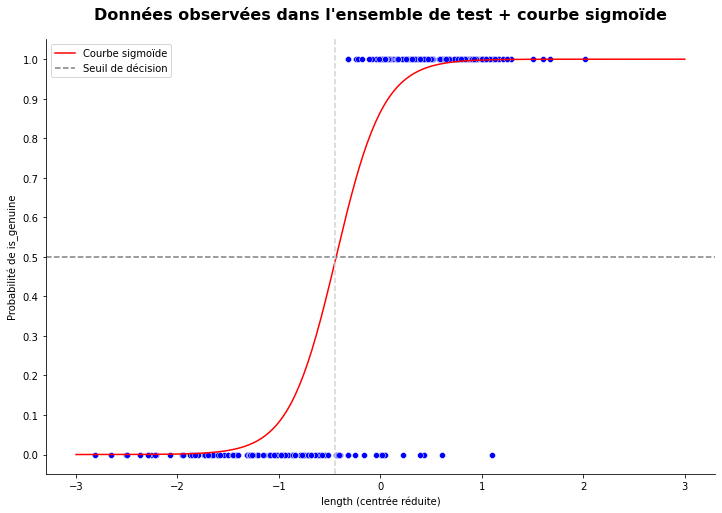


Le modèle le plus performant a classifié correctement 99.0 % des billets

              precision    recall  f1-score     support
False          1.000000  0.981818  0.990826  110.000000
True           0.989583  1.000000  0.994764  190.000000
accuracy       0.993333  0.993333  0.993333    0.993333
macro avg      0.994792  0.990909  0.992795  300.000000
weighted avg   0.993403  0.993333  0.993320  300.000000

Train score : 0.9925 | Test score : 0.9933

Meilleur score atteint pendant l'entraînement: 99.25

Meilleurs paramètres: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}



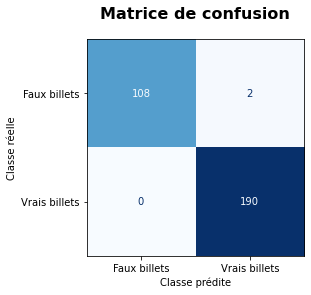

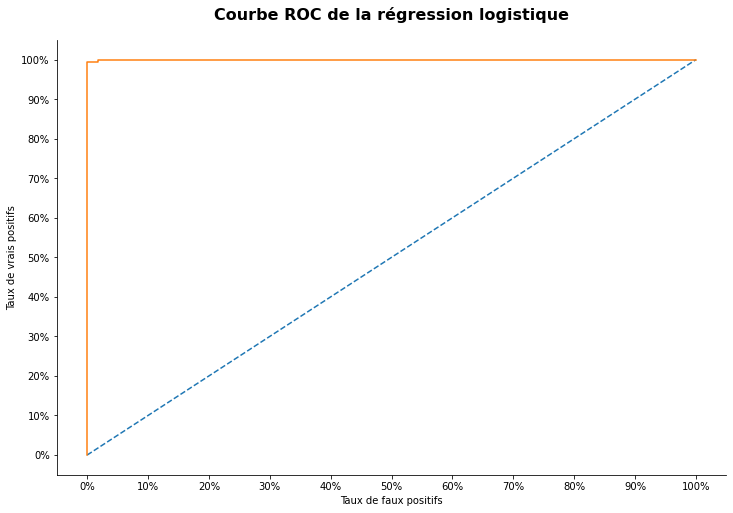

Aire sous la courbe ROC: 0.9999043062200957


In [60]:
# Utiliser la fonction ci-dessus pour effectuer la régression logistique
GridSearchCV_Logistic_Regression(X_train, X_test, y_train, y_test, 42, "length")

<div style='background-color: steelblue; padding: 20px'>
<h2 style='color: white; fontweight: bold'>Étape 3 - K-means</h2>
</div>

<div style='background-color: white; padding: 20px'>
<p style='color: black; fontweight: bold'>A présent, essayons de partitionner les données en deux clusters. <b>Dans l'idéal, l'un de ces clusters contiendra uniquement des faux billets et le deuxième uniquement des vrais billets. Ces deux clusters doivent donc être les plus homogènes possible</b>. On comparera ensuite les résulats du K-means à ceux de la régression logistique.</p>
</div>

In [61]:
# Fonction qui affiche le nombre de vrais et de faux billets présents dans chaque cluster
def kmeans_confusion_matrix(clusters):
    count = {}
    keys = list(clusters.keys())
    for key, value in clusters.items():
        most_frequent = statistics.mode(value)
        mode_count = value.count(most_frequent)
        homogeneity_rate = round(mode_count / len(value) * 100, 2)
        
        if most_frequent == 0:
            nb_false = mode_count
            nb_true = len(value) - nb_false
        else:
            nb_true = mode_count
            nb_false = len(value) - nb_true
        
        count[f"Cluster {keys[key]}"] = {"Nombre de vrais billets": nb_true, "Nombre de faux billets": nb_false, "Taux d'homogénéité": homogeneity_rate}
    
    count_df = pd.DataFrame(count)
    
    return count_df

In [62]:
# Fonction qui utilise l'algorithme k-means pour partitionner les données
def K_means_3D_clustering(nb_clusters, X_train, X_test, y_test, random_state, first_var_index, second_var_index, third_var_index):
    
    '''
    first_var_index: index de la première variable (colonne) utilisée dans le nuage de points en 3D
    second_var_index: index de la seconde variable...
    third_var_index: index de la troisième variable
    '''
    
    warnings.filterwarnings('ignore')
   
    labels = y_test.values

    colors = ['blue', 'red']

    # Exécuter K-means 
    clf = KMeans(n_clusters=nb_clusters, init='k-means++', n_init=3, max_iter=300, random_state=random_state).fit(X_train)
    predictions = clf.predict(X_test)

    clusters = {i: [] for i in range(nb_clusters)}
    for i, prediction in enumerate(predictions):
        clusters[prediction].append(labels[i])
    
    # Afficher la matrice de confusion
    print("----- Visualiser le nombre de vrais et de faux billets dans chaque cluster ------")
    print(kmeans_confusion_matrix(clusters))
    print()
        
    
    # On affiche un nuage de points en 3D car nous avons sélectionné 3 composantes
    fig = plt.figure(figsize=(16,12))
    ax = fig.add_subplot(111, projection='3d')

    for cluster, bills in clusters.items():
        print(f"Billets appartenant au cluster {cluster}: {bills}")
        points = np.array([X_test.iloc[i] for i in range(len(predictions)) if predictions[i] == cluster])
        ax.scatter(points[:, first_var_index], points[:, second_var_index], points[:, third_var_index], color=colors[cluster], edgecolor='black', linewidths=0.8, s=100) 
        ax.scatter([], [], [], color=colors[cluster], label=f"Cluster {cluster}", edgecolor='black', linewidths=0.8, s=100)


    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.title(f"K-means clustering sur l'ensemble de test", fontsize=16, fontweight='bold')
    plt.show()
    
    # On enregistre le meilleur modèle avec pickle.
    pickle.dump(clf, open('./kmeans_model.pkl', 'wb'))
            
    # return clusters

----- Visualiser le nombre de vrais et de faux billets dans chaque cluster ------
                         Cluster 0  Cluster 1
Nombre de vrais billets     188.00        2.0
Nombre de faux billets        1.00      109.0
Taux d'homogénéité           99.47       98.2

Billets appartenant au cluster 0: [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tr

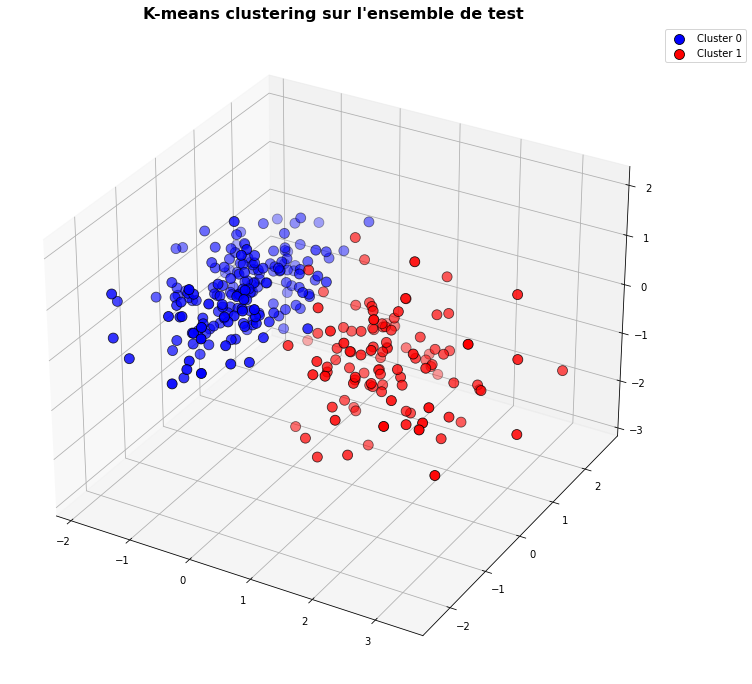

In [63]:
# Utiliser la fonction ci-dessus pour effectuer un clustering des billets
K_means_3D_clustering(2, X_train, X_test, y_test, 42, 3, 4, 5)

<div style='background-color: white; padding: 20px'>
<p style='color: black; fontweight: bold'>On constate que le K-means est tout aussi efficace pour faire distinguer les vrais des faux billets. Le taux d'homogénéité est très élevé.</p>
</div>

<div style='background-color: steelblue; padding: 20px'>
<h2 style='color: white; fontweight: bold'>Étape 4 - Réaliser une analyse en composantes principales (ACP)</h2>
</div>

<div style='background-color: white; padding: 20px'>
<p style='color: black; fontweight: bold'>Nous allons à présent réduire les données et vérifier s'il est possible d'obtenir d'aussi bons résultats en utilisant les composantes principales de notre jeu de données.</p>
</div>

In [64]:
# Retirer la variable cible du dataset d'origine
df_without_target = df.iloc[:,1:]
df_without_target.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54


In [65]:
# Centrer et réduire le dataframe à l'aide de la fonction ci-dessus
df_scaled = standardization(df_without_target)
df_scaled 

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.486540,2.774123,3.163240,0.056462,-1.128325,0.173651
1,-1.633729,-2.236535,-0.799668,-1.080631,-0.696799,0.471666
2,2.397823,1.504756,-1.291191,-0.125473,-0.912562,0.551901
3,-1.961498,-0.399294,0.060498,-1.308050,-0.610494,0.953075
4,-0.748754,0.836669,-1.414072,-0.671278,1.417677,-0.158750
...,...,...,...,...,...,...
1495,-0.683201,1.170713,0.767063,-0.095150,-0.265273,-1.602978
1496,0.758981,2.005822,1.596509,1.193555,0.942999,-1.958303
1497,-0.519316,-0.065250,0.613462,1.557425,0.899846,-0.835016
1498,0.332882,0.836669,0.429141,1.041943,1.331372,-0.491152


In [66]:
# Fonction qui génère et affiche le cercle des corrélations

def correlation_graph(pca, x_y, features):

    # Extrait x et y 
    x,y = x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(12, 8))

    texts = []
    
    # Générer une liste de couleurs
    colors = cm.viridis(np.linspace(0, 1, len(features)))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.04,
                head_length=0.04, 
                width=0.01, color=colors[i])

        # Les labels
        texts.append(plt.text(pca.components_[x, i] + 0.02,
                pca.components_[y, i] + 0.02,
                features[i], fontsize=10, color=colors[i]))


    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('PC{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('PC{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    plt.title("Cercle des corrélations (PC{} et PC{})".format(x+1, y+1), fontsize=16, fontweight='bold')

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))

    # Axes et display
    plt.axis('equal')

    # Ajustement automatique du texte
    adjust_text(texts)
    sns.despine()
    plt.show(block=False)

In [67]:
# Créer une fonction ACP

def Analyse_en_Composantes_Principales(scaled_df, labels_variable, number_components):
    
    '''
    Paramètres;
    
    scaled_df : dataframe centré réduit
    labels_variable : nom de la variable des labels, type string
    number_components :  nombre de composantes, type int
    '''
    
    # Lister les variables à utiliser pour l'analyse en composantes principales
    pca_variables = scaled_df.columns
    print('Variables utilisées:')
    print(f'{pca_variables}')
    print()
    
    # On récupère le label de chaque ligne du dataframe d'origine
    labels = df[labels_variable].values
    
    # Déterminer un nombre de composantes permettant de capter près de 90 % de l'inertie, 
    # puis instancier et entraîner l'ACP
    pca = PCA(n_components=number_components) # number_components ne peut pas dépasser le nombre de variables du jeu de données
    pca_data = pca.fit_transform(scaled_df)
    
    # Afficher la variance captée par chaque composante
    scree = (pca.explained_variance_ratio_*100).round(2)
    print(f'Pourcentage de variance captée par chacune des {number_components} composantes:')
    print(scree)
    print()
    
    # Afficher la variance captée cumulée (en %)
    cum_sum = scree.cumsum().round(2)
    print(f'Variance captée cumulée en %:')
    print(cum_sum)
    print()
    
    # Afficher l'éboulis des valeurs propres
    print('Visualiser l\'éboulis de valeurs propres:')
    components_list = range(1, number_components+1)
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    plt.bar(components_list, scree, color='blue')
    plt.plot(components_list, cum_sum, c="red", marker='o')
    plt.xlabel("Rang de l'axe d'inertie")
    plt.ylabel("Pourcentage d'inertie captée par un axe")
    plt.yticks(np.arange(0, 100, 5))
    plt.xticks(np.arange(1, number_components+1, 1))
    plt.title("Eboulis des valeurs propres", fontsize=16, fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.show(block=False)
    
    # Transformer les composantes principales en dataframe
    principal_components = pd.DataFrame(pca.components_)
    principal_components.columns = pca_variables
    
    # Nommer les index du dataframe principal_components PC1, PC2, etc
    components_list = range(1, number_components+1)
    principal_components.index = [f"PC{i}" for i in components_list]

    # Transposer le dataframe des composantes de façon à avoir celles-ci en colonnes et les variables en index
    # puis l'afficher
    print('Dataframe des composantes principales:')
    principal_components = principal_components.T

    return pca, pca_data, principal_components


Variables utilisées:
Index(['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
       'length'],
      dtype='object')

Pourcentage de variance captée par chacune des 6 composantes:
[43.21 16.96 13.02 11.83  9.66  5.33]

Variance captée cumulée en %:
[ 43.21  60.17  73.19  85.02  94.68 100.01]

Visualiser l'éboulis de valeurs propres:


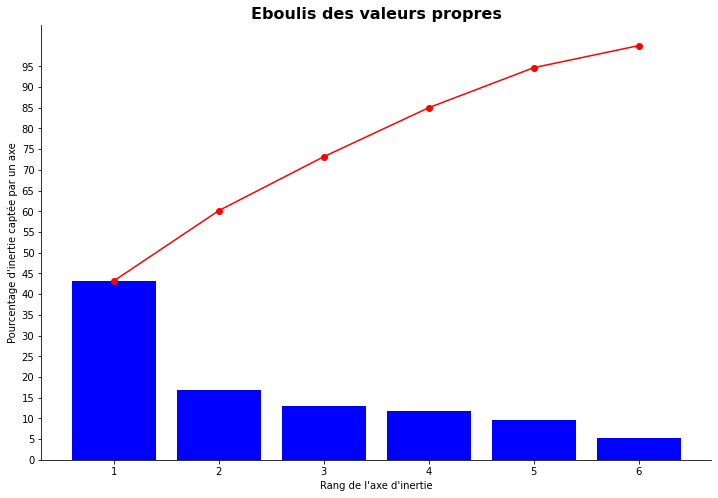

Dataframe des composantes principales:


(PCA(n_components=6),
 array([[ 1.64716429,  0.7472495 ,  2.39636562,  3.1847226 ,  0.29732302,
         -0.00844471],
        [-2.01970214, -2.20675832, -1.00231371,  0.07233277,  0.03810651,
         -0.47549589],
        [-0.96891668,  2.61937219,  1.20008898, -0.92470532, -0.83681788,
          0.19663021],
        ...,
        [ 1.88884875, -0.60085161, -0.54591505, -0.10035698, -0.303995  ,
          0.50353773],
        [ 1.78983604,  0.51094681,  0.02777919, -0.47366235,  0.35078122,
          0.53071532],
        [ 1.04315284, -1.47132486,  0.48277852, -0.68304951,  0.48997702,
         -0.22980172]]),
                    PC1       PC2       PC3       PC4       PC5       PC6
 diagonal     -0.084826  0.941309 -0.287081 -0.102802 -0.117041  0.007697
 height_left   0.331314  0.307256  0.884802 -0.047763  0.103105  0.006236
 height_right  0.393749  0.108588 -0.165502  0.866943  0.232737  0.004728
 margin_low    0.506602 -0.073121 -0.107145 -0.091559 -0.570821  0.626345
 margin_up 

In [68]:
# Effectuer une première ACP en utilisant la fonction ci-dessus
Analyse_en_Composantes_Principales(df_scaled, 'is_genuine', 6)

Variables utilisées:
Index(['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
       'length'],
      dtype='object')

Pourcentage de variance captée par chacune des 4 composantes:
[43.21 16.96 13.02 11.83]

Variance captée cumulée en %:
[43.21 60.17 73.19 85.02]

Visualiser l'éboulis de valeurs propres:


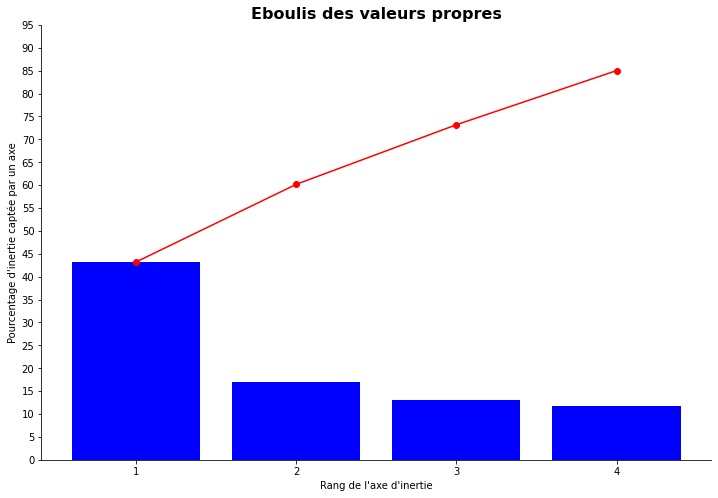

Dataframe des composantes principales:


(PCA(n_components=4),
 array([[ 1.64716429,  0.7472495 ,  2.39636562,  3.1847226 ],
        [-2.01970214, -2.20675832, -1.00231371,  0.07233277],
        [-0.96891668,  2.61937219,  1.20008898, -0.92470532],
        ...,
        [ 1.88884875, -0.60085161, -0.54591505, -0.10035698],
        [ 1.78983604,  0.51094681,  0.02777919, -0.47366235],
        [ 1.04315284, -1.47132486,  0.48277852, -0.68304951]]),
                    PC1       PC2       PC3       PC4
 diagonal     -0.084826  0.941309 -0.287081 -0.102802
 height_left   0.331314  0.307256  0.884802 -0.047763
 height_right  0.393749  0.108588 -0.165502  0.866943
 margin_low    0.506602 -0.073121 -0.107145 -0.091559
 margin_up     0.439347 -0.004474 -0.270935 -0.442480
 length       -0.527567  0.048710  0.149780  0.177167)

In [69]:
# Effectuer une deuxième ACP avec seulement 4 composantes
ACP = Analyse_en_Composantes_Principales(df_scaled, 'is_genuine', 4)
ACP

In [70]:
# Sauvegarder le modèle pca
saved_pca = ACP[0]
# On enregistre le meilleur modèle avec pickle.
pickle.dump(saved_pca, open('./pca_model.pkl', 'wb'))

In [71]:
# Lister les variables à utiliser
variables = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']

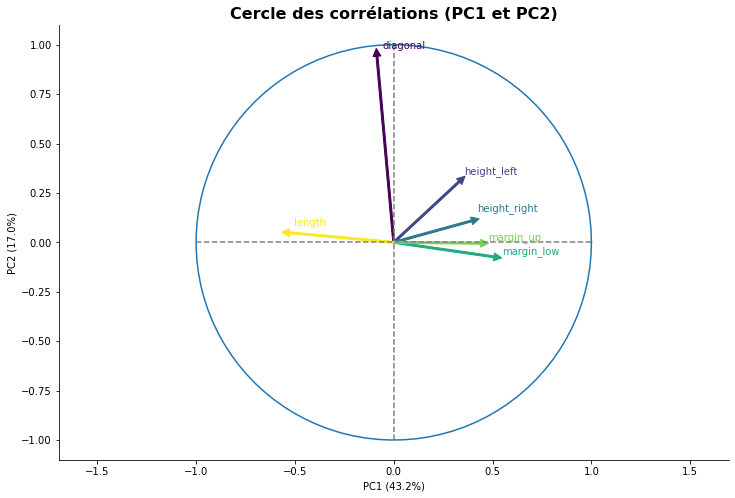

In [72]:
# Afficher le cercle des corrélations pour PC1 et PC2
x_y = (0,1)
correlation_graph(ACP[0], x_y, variables)

<div style='background-color: white; padding: 20px'>
<p style='color: black'>On remarque que les variables les plus corrélées à l'axe horizontal PC1 sont les marges (haute et basse) et la longueur. On constate également que les marges et la longueur d'un billet sont négativement corrélées; plus les marges sont hautes moins la longueur est grande et vice versa. <br><b>On peut donc définir PC1 comme étant la composante "Marges et longueur d'un billet"</b>.<br><br>Ensuite, la variable la plus corrélée à l'axe vertical PC2 est 'diagonal'. <br><b>On peut définir PC2 comme étant la composante diagonale</b>.</p>
</div>

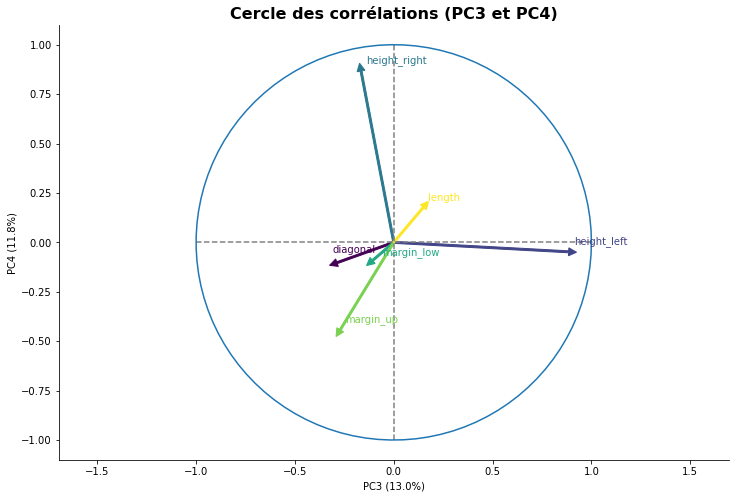

In [73]:
# Visualiser les corrélations sur les axes PC3 et PC4
x_y = (2,3)
correlation_graph(ACP[0], x_y, variables) 

<div style='background-color: white; padding: 20px'>
<p style='color: black'>'height left' est la variable la plus corrélée à l'axe horizontal PC3 tandis que 'height_right' est fortement corrélée à l'axe vertical PC4. Nous avons de la redondance car la hauteur gauche diffère très peu de la hauteur droite.<br><b>On peut se contenter d'utiliser uniquement PC3 et la définir comme la composante hauteur d'un billet</b>.</p>
</div>

<div style='background-color: steelblue; padding: 20px'>
<h2 style='color: white; fontweight: bold'>Étape 5 - Régression logistique avec les composantes principales</h2>
</div>

In [74]:
# récupérer le numpy array pca_data retourné précédemment par la fonction Analyse_en_Composantes_Principales
# c'est à dire ACP[1], puis le transformer en dataframe:
pca_data = pd.DataFrame(ACP[1])
pca_data.rename(columns={0:"PC1",1:"PC2",2:"PC3", 3:"PC4"}, inplace=True)
pca_data

,PC1,PC2,PC3,PC4
0,1.647164,0.747249,2.396366,3.184723
1,-2.019702,-2.206758,-1.002314,0.072333
2,-0.968917,2.619372,1.200089,-0.924705
3,-1.375774,-1.817690,0.648106,0.831914
4,0.150457,-0.566280,0.853318,-1.782867
...,...,...,...,...
1495,1.428784,-0.270038,0.947005,0.521412
1496,3.280895,1.317216,0.615952,0.336768
1497,1.888849,-0.600852,-0.545915,-0.100357
1498,1.789836,0.510947,0.027779,-0.473662


In [75]:
# Train test split avec les composantes principales de l'ACP effectuée précédemment
X_train, X_test, y_train, y_test = train_test_split(pca_data, y, train_size=0.80, random_state=42)

In [76]:
# Afficher X_train
X_train

,PC1,PC2,PC3,PC4
382,-0.377927,1.636516,1.752611,-0.212502
538,-1.418121,0.255940,2.258296,-0.345742
1493,2.253144,-0.551701,0.460805,1.360063
1112,2.456979,0.513500,-0.058538,0.363900
324,-1.110843,0.805100,1.648740,-0.291502
...,...,...,...,...
1130,2.048310,-0.949491,0.371676,-0.153367
1294,1.365726,1.597352,-0.082021,0.227983
860,-0.552885,-1.916119,0.100454,0.641147
1459,2.667098,-0.573207,0.391204,-0.989310


In [77]:
# Fonction régression logistique qui utilise les composantes principales
def LogisticRegression_PCA(X_train, X_test, y_train, y_test, random_state):
    # Instancier un classifieur 
    classifier = LogisticRegression(random_state=random_state)
    classifier.fit(X_train, y_train)   
    
    # Effectuer des prédictions sur l'ensemble de test
    y_pred = classifier.predict(X_test)
    
    # Calculer les probabilités qu'un individu appartienne à la classe 0, à la classe 1
    y_pred_proba = classifier.predict_proba(X_test)[:,1]
    
    # Afficher l'accuracy score du meilleur modèle
    score = round(classifier.score(X_test, y_test),2)
    print()
    print('Le modèle a classifié correctement {} % des billets'.format(str(score*100)))
    print()

    # Afficher le rapport de classification
    report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
    print(report)
    print()
    
        
    # Afficher la matrice de confusion
    conf_matrix = confusion_matrix(y_test, y_pred)
    display_matrix = ConfusionMatrixDisplay(conf_matrix, display_labels=['Faux billets', 'Vrais billets'])
    display_matrix.plot(cmap='Blues', colorbar=False)
    plt.title('Matrice de confusion', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Classe prédite')
    plt.ylabel('Classe réelle')
    plt.show()
    
    # Récupérer le taux de vrais positifs et le taux de faux positifs
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    # Visualiser le taux de faux positifs (axe des abscisses) versus le taux de vrais positifs (axe des ordonnées)
    plt.figure(figsize=(12,8))
    plt.plot([0,1], [0,1], '--')
    plt.plot(fpr,tpr)
    plt.title('Courbe ROC', fontsize=16, fontweight='bold', pad=10)
    plt.ylabel('Taux de vrais positifs')
    plt.xlabel('Taux de faux positifs')
    xticks = np.arange(0.00, 1.01, 0.10) 
    xlabels = [f'{x*100:.0f}%' for x in xticks]
    plt.xticks(xticks, labels=xlabels)
    yticks = np.arange(0.00, 1.01, 0.10) 
    ylabels = [f'{y*100:.0f}%' for y in yticks] 
    plt.yticks(yticks, labels=ylabels)
    sns.despine()
    plt.show()
    
    # Calcul de l'aire sous la courbe ROC, plus celle-ci est proche de 1 et plus le modèle est bon
    au_roc_curve = roc_auc_score(y_test, y_pred_proba)
    print('Aire sous la courbe ROC: {}'.format(au_roc_curve))
    
    # On enregistre le modèle avec pickle.
    pickle.dump(classifier, open('./log_reg_pca_model.pkl', 'wb'))



Le modèle a classifié correctement 99.0 % des billets

              precision    recall  f1-score     support
False          0.990741  0.972727  0.981651  110.000000
True           0.984375  0.994737  0.989529  190.000000
accuracy       0.986667  0.986667  0.986667    0.986667
macro avg      0.987558  0.983732  0.985590  300.000000
weighted avg   0.986709  0.986667  0.986640  300.000000



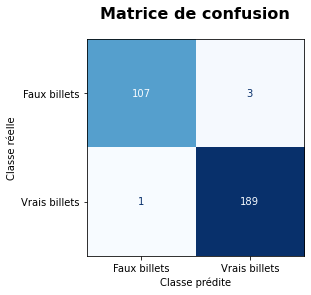

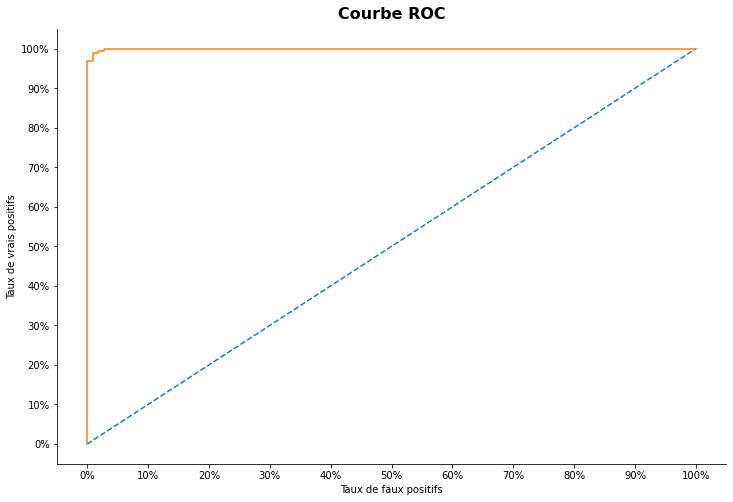

Aire sous la courbe ROC: 0.9995693779904307


In [78]:
# Effectuer la régression logistique sur les composantes principales
LogisticRegression_PCA(X_train, X_test, y_train, y_test, 42)

<div style='background-color: steelblue; padding: 20px'>
<h2 style='color: white; fontweight: bold'>Étape 6 - K-means avec les composantes principales</h2>
</div>

<div style='background-color: white; padding: 20px'>
<p style='color: black; fontweight: bold'>Essayons également le K-means sur les composantes principales.</p>
</div>

In [79]:
# Créer une fonction qui Utilisera les 3 premières composantes principales de l'ACP avec le K-means
def K_means_pca_clustering(nb_clusters, X_train, X_test, y_test, random_state, PC1_index, PC2_index, PC3_index):
    
    warnings.filterwarnings('ignore')
    
    # # Récupérer le modèle pca entraîné précédemment
    # with open(pca_model_path, 'rb') as f:
    #     pca = pickle.load(f)
    # pca_data = pca.fit_transform(df_scaled)

    labels = y_test.values

    colors = ['blue', 'red']

    # Exécuter K-means 
    clf = KMeans(n_clusters=nb_clusters, init='k-means++', n_init=3, max_iter=300, random_state=random_state).fit(X_train)
    predictions = clf.predict(X_test)

    clusters = {i: [] for i in range(nb_clusters)}
    for i, prediction in enumerate(predictions):
        clusters[prediction].append(labels[i])
    
    # Utiliser la fonction créée plus haut pour visualiser l'homogénéité de chaque cluster
    print('------ Visualiser le nombre de vrais et de faux billets se trouvant dans chaque cluster ------')
    print(kmeans_confusion_matrix(clusters))

    # On affiche un nuage de points en 3D car nous avons sélectionné 3 composantes
    fig = plt.figure(figsize=(16,12))
    ax = fig.add_subplot(111, projection='3d')

    for cluster, bills in clusters.items():
        points = np.array([X_test.iloc[i] for i in range(len(predictions)) if predictions[i] == cluster])
        ax.scatter(points[:, PC1_index], points[:, PC2_index], points[:, PC3_index], color=colors[cluster], edgecolor='black', linewidths=0.8, s=100) 
        ax.scatter([], [], [], color=colors[cluster], label=f"Cluster {cluster}", edgecolor='black', linewidths=0.8, s=100) 

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')

    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.title(f'K-means clustering en utilisant les composantes principales', fontsize=16, fontweight='bold')
    plt.show()
    
    # On enregistre le meilleur modèle avec pickle.
    pickle.dump(clf, open('./kmeans_pca_model.pkl', 'wb'))
            
    # return clusters

------ Visualiser le nombre de vrais et de faux billets se trouvant dans chaque cluster ------
                         Cluster 0  Cluster 1
Nombre de vrais billets     187.00       3.00
Nombre de faux billets        1.00     109.00
Taux d'homogénéité           99.47      97.32


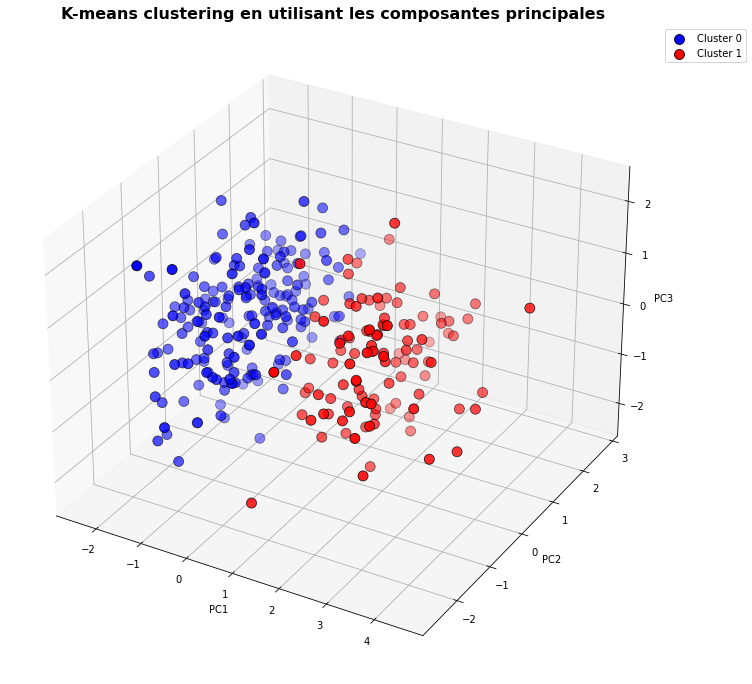

In [80]:
# Utiliser la fonction ci-dessus pour effectuer un clustering des billets
K_means_pca_clustering(2, X_train, X_test, y_test, 42, 0, 1, 2)


<div style='background-color: white; padding: 20px'>
<p style='color: black; fontweight: bold'>Les modèles entraînés sur les composantes principales donnent des résultats légèrement moins bons, ce qui n'a rien d'étonnant puisque nous avons perdu de l'information en réduisant le nombre de variables. Mais ces résultats restent plus que satisfaisants.</p>
</div>

<div style='background-color: steelblue; padding: 20px'>
<h2 style='color: white; fontweight: bold'>Étape 7 - Algorithme final</h2>
</div>

<div style='background-color: white; padding: 20px'>
<p style='color: black; fontweight: bold'>Notre algorithme final sera une classe python qui fera appel à l'un des 4 modèles entraînés et sauvegardés précédemment pour classifier (ou partitionner) de nouvelles données.</p>
</div>

In [81]:
# Créer une classe pour la détection de faux billets
class Counterfeit_Money_Detection:
    '''
    pca_path : chemin d'accès au modèle pca si l'algorithme choisi est le K-means
    
    '''
    def __init__(self, csv_path, classifier_path, pca_model_path=None, first_var_index=None, second_var_index=None, third_var_index=None):
        self.csv_path = csv_path
        self.classifier_path = classifier_path
        self.pca_model_path = pca_model_path
        self.first_var_index = first_var_index
        self.second_var_index = second_var_index
        self.third_var_index = third_var_index
        
    def predict(self):
        if self.classifier_path == 'log_reg_model.pkl':
            # Charger le fichier contenant les données à prédire
            df = pd.read_csv(self.csv_path)
            print("------ Dataframe d'origine ------")
            print()
            print(df.head(10))
            
            # Ne conserver que les 6 variables explicatives
            columns = ['diagonal', 'height_left', 'height_right', 'margin_low',	'margin_up', 'length']
            df_independent = df[columns]
                        
            # Instancier un scaler
            scaler = StandardScaler()

            # Ajustement et transformation des données
            df_scaled = scaler.fit_transform(df_independent)

            # Conversion du tableau numpy en dataframe
            self.df_scaled = pd.DataFrame(df_scaled, index=df.index, columns=df_independent.columns)
                
            # Charger le modèle entraîné précédemment 
            with open(self.classifier_path, 'rb') as f:
                clf = pickle.load(f)
                
            # puis effectuer des prédictions sur les nouvelles données...
            self.predict = clf.predict(df_scaled)
            
            # ...et récupérer, pour chaque billet, les probabilités que ledit billet appartienne 
            # à la classe des faux billets et à la classe des vrais billets
            # soit un array avec 2 probabilités pour chaque billet
            self.proba = clf.predict_proba(df_scaled)
            
            # Transformer le array des prédictions en Series
            series_predict =  pd.Series(self.predict).T.astype(bool)
            
            # Transformer le array des probabilités en dataframe
            df_proba = pd.DataFrame(self.proba)
            df_proba.rename(columns={0:'probability_of_being_counterfeit', 1:'probability_of_being_genuine'}, inplace=True)
            df_proba['probability_of_being_genuine'] = round(df_proba['probability_of_being_genuine'],3)
            df_proba['probability_of_being_counterfeit'] = round(df_proba['probability_of_being_counterfeit'],3)
            
            # Fusionner df, df_proba et series_predict
            df_proba_predict = df.merge(df_proba, left_index=True, right_index=True).merge(series_predict.rename('is_genuine'), left_index=True, right_index=True)
            
            print()
            print("------ Visualiser les prédictions ------")
            plt.figure(figsize=(9,6))
            sns.scatterplot(data=df_proba_predict, x='id', y='is_genuine', hue='is_genuine', palette=['red', 'blue'], s=100)
            plt.title('Prédictions de classe', fontsize=16, pad=20)
            plt.xlabel('id')
            plt.ylabel('is_genuine')
            plt.yticks(np.arange(0, 2))
            sns.despine()
            plt.show()
            
            print()
            print("------ Dataframe d'origine + probabilités + prédiction ------")
            return df_proba_predict
        
        elif self.classifier_path == 'kmeans_model.pkl':
            # Charger le fichier contenant les données à prédire / partitionner
            df = pd.read_csv(self.csv_path)
            print("------ Dataframe d'origine ------")
            print()
            print(df.head(10))
            print()
            
            # Ne conserver que les 6 variables explicatives
            columns = ['diagonal', 'height_left', 'height_right', 'margin_low',	'margin_up', 'length']
            df_independent = df[columns]
            
            labels = df.id.values
            
            # Instancier un scaler
            scaler = StandardScaler()

            # Ajustement et transformation des données
            df_scaled = scaler.fit_transform(df_independent)

            # Conversion du tableau numpy en dataframe
            self.df_scaled = pd.DataFrame(df_scaled, index=df.index, columns=df_independent.columns)
                
            # Charger le modèle entraîné précédemment 
            with open(self.classifier_path, 'rb') as f:
                clf = pickle.load(f)
                
            # puis effectuer des prédictions sur les nouvelles données...
            self.predict = clf.predict(df_scaled)
            
            # 2 clusters car on souhaite partitionner les données en deux; vrais billets d'un côté et faux billets de l'autre
            clusters = {i: [] for i in range(2)}
            for i, prediction in enumerate(self.predict):
                clusters[prediction].append(labels[i])
            
    
            # Nuage de points en 3D
            fig = plt.figure(figsize=(16,12))
            ax = fig.add_subplot(111, projection='3d')
            colors = ['blue', 'red']
    
            for cluster, bills in clusters.items():
                # print(f"Billets appartenant au cluster {cluster}: {bills}")
                points = np.array([df_scaled[i] for i in range(len(self.predict)) if self.predict[i] == cluster])
                ax.scatter(points[:, self.first_var_index], points[:, self.second_var_index], points[:, self.third_var_index], color=colors[cluster], edgecolor='black', linewidths=0.8, s=180) 
                ax.scatter([], [], [], color=colors[cluster], label=f"Cluster {cluster}", edgecolor='black', linewidths=0.8, s=100)
                for index, bill in enumerate(bills):
                    ax.text(points[index, self.first_var_index], points[index, self.second_var_index], points[index, self.third_var_index], bill, fontsize=16, ha='right', va='bottom', 
                        bbox=dict(facecolor='white', alpha=0.3, edgecolor='none'))
                    
            plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
            plt.title(f"Clustering des billets en 3D", fontsize=16, fontweight='bold')
            plt.show()
            
        elif self.classifier_path == 'log_reg_pca_model.pkl':
            # Charger le fichier contenant les données à prédire
            df = pd.read_csv(self.csv_path)
            print("------ Dataframe d'origine ------")
            print()
            print(df.head(10))
            
            # Ne conserver que les 6 variables explicatives
            columns = ['diagonal', 'height_left', 'height_right', 'margin_low',	'margin_up', 'length']
            df_independent = df[columns]
            
            # Instancier un scaler
            scaler = StandardScaler()

            # Ajustement et transformation des données
            df_scaled = scaler.fit_transform(df_independent)

            # Conversion du tableau numpy en dataframe
            self.df_scaled = pd.DataFrame(df_scaled, index=df.index, columns=df_independent.columns)
            
            # Récupérer le modèle pca entraîné précédemment
            with open(self.pca_model_path, 'rb') as f:
                pca = pickle.load(f)
            pca_data = pca.fit_transform(self.df_scaled)
            
            # Récupérer le modèle entraîné précédemment 
            # puis effectuer des prédictions sur les nouvelles données
            with open(self.classifier_path, 'rb') as f:
                clf = pickle.load(f)
            self.predict = clf.predict(pca_data)
            
            # ...et récupérer, pour chaque billet, les probabilités que ledit billet appartienne 
            # à la classe des faux billets et à la classe des vrais billets
            # soit un array avec 2 probabilités pour chaque billet
            self.proba = clf.predict_proba(pca_data)
            
            # Transformer le array des prédictions en Series
            series_predict =  pd.Series(self.predict).T.astype(bool)
            
            # Transformer le array des probabilités en dataframe
            df_proba = pd.DataFrame(self.proba)
            df_proba.rename(columns={0:'probability_of_being_counterfeit', 1:'probability_of_being_genuine'}, inplace=True)
            df_proba['probability_of_being_genuine'] = round(df_proba['probability_of_being_genuine'],3)
            df_proba['probability_of_being_counterfeit'] = round(df_proba['probability_of_being_counterfeit'],3)
            
            # Fusionner df, df_proba et series_predict
            df_proba_predict = df.merge(df_proba, left_index=True, right_index=True).merge(series_predict.rename('is_genuine'), left_index=True, right_index=True)
            
            print()
            print("------ Visualiser les prédictions ------")
            plt.figure(figsize=(9,6))
            sns.scatterplot(data=df_proba_predict, x='id', y='is_genuine', hue='is_genuine', palette=['red', 'blue'], s=100)
            plt.title('Prédictions de classe', fontsize=16, pad=20)
            plt.xlabel('id')
            plt.ylabel('is_genuine')
            plt.yticks(np.arange(0, 2))
            sns.despine()
            plt.show()
            
            print()
            print("------ Dataframe avec les prédictions ------")
            return df_proba_predict
        
        elif self.classifier_path == 'kmeans_pca_model.pkl':
            # Charger le fichier contenant les données à prédire
            df = pd.read_csv(self.csv_path)
            print("------ Dataframe d'origine ------")
            print()
            print(df.head(10))
            
            # Ne conserver que les 6 variables explicatives
            columns = ['diagonal', 'height_left', 'height_right', 'margin_low',	'margin_up', 'length']
            df_independent = df[columns]
            labels = df.id.values
            
            # Instancier un scaler
            scaler = StandardScaler()

            # Ajustement et transformation des données
            df_scaled = scaler.fit_transform(df_independent)

            # Conversion du tableau numpy en dataframe
            self.df_scaled = pd.DataFrame(df_scaled, index=df.index, columns=df_independent.columns)
           
            # Récupérer le modèle pca entraîné précédemment
            with open(self.pca_model_path, 'rb') as f:
                pca = pickle.load(f)
            pca_data = pca.fit_transform(self.df_scaled)
            
            # Récupérer le modèle entraîné précédemment 
            # puis effectuer des prédictions sur les nouvelles données
            with open(self.classifier_path, 'rb') as f:
                clf = pickle.load(f)
            self.predict = clf.predict(pca_data)
           
            # 2 clusters car on souhaite partitionner les données en deux; vrais billets d'un côté et faux billets de l'autre
            clusters = {i: [] for i in range(2)}
            for i, prediction in enumerate(self.predict):
                clusters[prediction].append(labels[i])
            
    
            # Nuage de points en 3D
            fig = plt.figure(figsize=(16,12))
            ax = fig.add_subplot(111, projection='3d')
            colors = ['blue', 'red']
    
            for cluster, bills in clusters.items():
                print(f"Billets appartenant au cluster {cluster}: {bills}")
                points = np.array([pca_data.iloc[i] for i in range(len(self.predict)) if self.predict[i] == cluster])
                ax.scatter(points[:, self.first_var_index], points[:, self.second_var_index], points[:, self.third_var_index], color=colors[cluster], edgecolor='black', linewidths=0.8, s=180) 
                ax.scatter([], [], [], color=colors[cluster], label=f"Cluster {cluster}", edgecolor='black', linewidths=0.8, s=100)
                for index, bill in enumerate(bills):
                    ax.text(points[index, self.first_var_index], points[index, self.second_var_index], points[index, self.third_var_index], bill, fontsize=16, ha='right', va='bottom', 
                        bbox=dict(facecolor='white', alpha=0.3, edgecolor='none'))
                    
            plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
            plt.title(f"Clustering des billets en 3D", fontsize=16, fontweight='bold')
            plt.show()
           
        else:
            raise ValueError("Ce chemin d'accès n'est pas valide")
            

<div style='background-color: white; padding: 20px'>
<p style='color: red'><b>Rappel:</b> <br><b>Un faux billet a généralement une hauteur et des marges (marge haute et marge basse) plus grandes que celles d'un vrai billet, tandis que sa longueur et sa diagonale sont plus petites</b>.<br></p><p style='color: black'></p>
</div>

------ Dataframe d'origine ------

   diagonal  height_left  height_right  margin_low  margin_up  length   id
0    172.09       103.95        103.73        4.39       3.09  113.19  B_1
1    171.52       104.17        104.03        5.27       3.16  111.82  B_2
2    171.78       103.80        103.75        3.81       3.24  113.39  B_3
3    172.02       104.08        103.99        5.57       3.30  111.10  B_4
4    171.79       104.34        104.37        5.00       3.07  111.87  B_5

------ Visualiser les prédictions ------


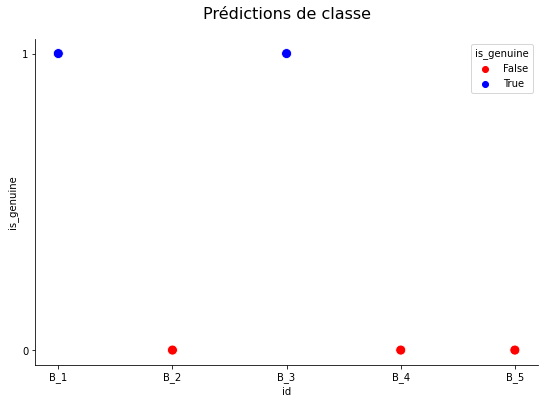


------ Dataframe d'origine + probabilités + prédiction ------


,diagonal,height_left,height_right,margin_low,margin_up,length,id,probability_of_being_counterfeit,probability_of_being_genuine,is_genuine
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1,0.000,1.000,True
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2,0.938,0.062,False
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3,0.000,1.000,True
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4,1.000,0.000,False
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5,0.704,0.296,False


In [83]:
# Tester l'algorithme avec le fichier billet_production.csv

# Sans ACP
clf = Counterfeit_Money_Detection('billets_test.csv', 'log_reg_model.pkl', 'pca_model.pkl', 3, 4, 5)
# clf = Counterfeit_Money_Detection('billets_test.csv', 'kmeans_model.pkl', 'pca_model.pkl', 3, 4, 5)

# # Avec ACP
# clf = Counterfeit_Money_Detection('billets_production.csv', 'log_reg_pca_model.pkl', 'pca_model.pkl', 0, 1, 2)
# clf = Counterfeit_Money_Detection('billets_production.csv', 'kmeans_pca_model.pkl', 'pca_model.pkl', 0, 1, 2)

clf.predict()